In [1]:
import sys
import os
from pathlib import Path
import importlib

# The notebooks are in a 'notebooks' subfolder, so workspace root is one level up
# This works if notebook is in notebooks/ folder
workspace_root = Path.cwd().parent.resolve()

# Add workspace root to path so we can import from src
sys.path.insert(0, str(workspace_root))

WORKSPACE_ROOT = workspace_root
DATA_DIR = WORKSPACE_ROOT / "data"
DATA_XLSX = DATA_DIR / "daily_energy.xlsx"
DATA_XLSX_HISTORICAL = DATA_DIR / "daily_energy_historical.xlsx"
CACHE_DIR = WORKSPACE_ROOT / "pvgis_cache"
PLOTS_DIR = WORKSPACE_ROOT / "plots"
DATA_XLSX_HISTORICAL = DATA_DIR / "daily_energy_historical.xlsx"
DATA_XLSX_TOTAL_IRR = DATA_DIR / "Exported Data-20150101T000000.xlsx"
DATA_XLSX_TOTAL_FULL = DATA_DIR / "column_full_export.xlsx"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import pvgis_pi_heatmap
importlib.reload(pvgis_pi_heatmap)  # Reload to pick up any changes

from src.pvgis_pi_heatmap import make_random_greece_meta, compute_pi_anomaly, short_label, parse_kwp_from_header
from src.utils import save_figure


In [2]:
import importlib
import sys
import re
from pathlib import Path

def recompute_sanitized_columns(
    workspace_root: Path | str | None = None,
    resanitize_current: bool = False,
) -> Path:
    """Recompute sanitized columns from inbox files and write a new versioned mapping."""
    root = Path(workspace_root) if workspace_root else WORKSPACE_ROOT
    src_path = root / "src"
    if str(src_path) not in sys.path:
        sys.path.append(str(src_path))

    import scada_column_sanitizer as scs
    importlib.reload(scs)

    inbox_dir = root / "data" / "inbox"
    allowed_ext = {".xlsx", ".xls", ".xlsm", ".csv", ".txt"}
    inbox_files = []
    if inbox_dir.exists():
        inbox_files = [p for p in inbox_dir.iterdir() if p.is_file() and p.suffix.lower() in allowed_ext]
    elif not resanitize_current:
        raise FileNotFoundError(f"Inbox folder not found: {inbox_dir}")

    if not inbox_files and not resanitize_current:
        raise FileNotFoundError(f"No files found in inbox: {inbox_dir}")

    columns = []
    for p in inbox_files:
        cols = scs.read_columns_only(str(p), sheet_name=0)
        columns.extend(cols)

    columns = list(dict.fromkeys(columns))
    cfg = scs.SanitizeConfig(prompt_missing_capacity=True, default_capacity_kwp=None)
    sanitizer = scs.ScadaColumnSanitizer(config=cfg)

    mappings_dir = root / "mappings"
    mappings_dir.mkdir(parents=True, exist_ok=True)
    current_txt = mappings_dir / "current.txt"

    base_mapping = {}
    mapping_files = sorted(mappings_dir.glob("park_power_mapping_v*.csv"))
    current_mapping_path = None
    if current_txt.exists():
        current_mapping_file = current_txt.read_text(encoding="utf-8").strip()
        current_mapping_path = mappings_dir / current_mapping_file

    if mapping_files:
        for f in mapping_files:
            base_mapping.update(sanitizer.load_mapping_csv(f))
        print(f"Loaded {len(mapping_files)} mapping versions, {len(base_mapping)} total entries.")
    elif current_mapping_path and current_mapping_path.exists():
        base_mapping = sanitizer.load_mapping_csv(current_mapping_path)
        print(f"Loaded existing mapping: {current_mapping_path.name}")
    else:
        print("No existing mapping found (first run)")

    originals = list(dict.fromkeys(list(base_mapping.keys()) + columns))
    if not originals:
        raise RuntimeError("No columns available to sanitize. Check inbox or mapping files.")

    if resanitize_current:
        sanitized, mapping = sanitizer.sanitize_columns(originals, existing_mapping={})
        full_mapping = mapping
    else:
        sanitized, mapping = sanitizer.sanitize_columns(originals, existing_mapping=base_mapping)
        full_mapping = dict(base_mapping)
        full_mapping.update(mapping)

    print("\nRecomputed sanitized columns. Showing first 10:")
    for c in sanitized[:10]:
        print(" -", c)
    print(f"Total mappings: {len(full_mapping)}")

    if base_mapping and full_mapping == base_mapping:
        print("No new columns detected; skipping new mapping version.")
        if current_mapping_path and current_mapping_path.exists():
            return current_mapping_path
        if mapping_files:
            return mapping_files[-1]
        raise RuntimeError("No existing mapping file found to return.")

    version_pattern = re.compile(r"park_power_mapping_v(\d+)\.csv")
    versions = []
    for f in mappings_dir.glob("park_power_mapping_v*.csv"):
        m = version_pattern.match(f.name)
        if m:
            versions.append(int(m.group(1)))
    next_version = max(versions, default=0) + 1

    new_mapping_filename = f"park_power_mapping_v{next_version:03d}.csv"
    new_mapping_path = mappings_dir / new_mapping_filename

    import csv
    new_mapping_path.parent.mkdir(parents=True, exist_ok=True)
    with open(new_mapping_path, "w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["original", "sanitized"])
        for orig in sorted(full_mapping):
            writer.writerow([orig, full_mapping[orig]])

    print(f"\nSaved new mapping version: {new_mapping_filename}")

    current_txt.write_text(new_mapping_filename, encoding="utf-8")
    print(f"Updated mappings/current.txt -> {new_mapping_filename}")

    print("\nMapping versioning system:")
    print(f"   Location: mappings/{new_mapping_filename}")
    print("   Active: Yes (current.txt points to this version)")
    print("   To rollback: edit mappings/current.txt")

    return new_mapping_path

# Uncomment to run when needed
# recompute_sanitized_columns()
# recompute_sanitized_columns(resanitize_current=True)


In [3]:
# Run bronze ingestion with versioned mapping support
# Reads mappings/current.txt to determine active mapping file
from pathlib import Path
import importlib
from src import bronze_ingest as bi

# Reload module to pick up any code changes
importlib.reload(bi)

# Paths
DATA_ROOT = WORKSPACE_ROOT / "data"
BRONZE_ROOT = WORKSPACE_ROOT / "bronze"
MAPPINGS_ROOT = WORKSPACE_ROOT / "mappings"

# Ensure expected folders exist
for p in [
    DATA_ROOT / "inbox",
    DATA_ROOT / "processing",
    DATA_ROOT / "archived",
    DATA_ROOT / "rejected",
    DATA_ROOT / "_locks",
    BRONZE_ROOT,
    MAPPINGS_ROOT,
]:
    p.mkdir(parents=True, exist_ok=True)

# Build config (min_age_seconds=0 to ingest immediately in notebook)
cfg = bi.Config(
    data_root=DATA_ROOT,
    inbox=DATA_ROOT / "inbox",
    processing=DATA_ROOT / "processing",
    archived=DATA_ROOT / "archived",
    rejected=DATA_ROOT / "rejected",
    bronze_root=BRONZE_ROOT,
    mappings_root=MAPPINGS_ROOT,
    dataset_name="scada_1d_signal",
    timezone_local="Europe/Athens",
    daily_interval_end_is_midnight=True,
    parquet_compression="zstd",
    min_age_seconds=0,
    stable_check_seconds=0,
    sheet_name=None,
    csv_sep=None,
    csv_encoding=None,
    allow_duplicates=False,
)

cfg.lockfile = DATA_ROOT / "_locks" / "bronze_ingest.lock"

# Run ingestion (reads mappings/current.txt to find active mapping, applies it, writes bronze with mapping metadata)
print(f"Mappings root: {MAPPINGS_ROOT}")
print(f"Current mapping: {(MAPPINGS_ROOT / 'current.txt').read_text().strip()}")

Mappings root: C:\00_Developement\daily_avg_pv_kpi_heatmap\mappings
Current mapping: park_power_mapping_v008.csv


In [4]:
# bi.reset_dataset(cfg, remove_run_logs=True)
bi.ingest_folder(cfg)

No files found in inbox.


In [5]:
from pathlib import Path
import json
import pandas as pd

def load_new_bronze_parts_from_runlogs(
    bronze_root: Path,
    state_path: Path,
    dataset_name: str = "scada_1d_signal",
) -> pd.DataFrame:
    """
    Loads parquet parts from new runs using run logs as the source of truth.
    Updates state_path to the newest processed run_id if load succeeds.
    """
    runlog_dir = bronze_root / "_ops" / "run_logs"
    if not runlog_dir.exists():
        return pd.DataFrame()

    # Read last processed run_id (watermark)
    last_run_id = "00000000T000000Z"
    if state_path.exists():
        last_run_id = state_path.read_text(encoding="utf-8").strip() or last_run_id

    # Collect run log files newer than watermark
    runlog_files = sorted(runlog_dir.glob("run_*.json"))
    new_runlogs = [p for p in runlog_files if p.stem.replace("run_", "") > last_run_id]

    if not new_runlogs:
        return pd.DataFrame()

    # Collect parquet files from run logs
    parquet_files = []
    newest_run_id = last_run_id
    for p in new_runlogs:
        payload = json.loads(p.read_text(encoding="utf-8"))
        if payload.get("dataset") != dataset_name:
            continue
        run_id = payload.get("run_id")
        if run_id and run_id > newest_run_id:
            newest_run_id = run_id
        parquet_files.extend(payload.get("files_written", []))

    if not parquet_files:
        return pd.DataFrame()

    # Load parts; concat handles minor schema drift
    dfs = [pd.read_parquet(f) for f in parquet_files]
    df_new = pd.concat(dfs, ignore_index=True)

    # Update watermark only after successful load
    state_path.parent.mkdir(parents=True, exist_ok=True)
    state_path.write_text(newest_run_id, encoding="utf-8")

    return df_new


## End of Bronze Database Level

## Silver prep (bronze -> silver)


In [6]:
from src import silver_prepair as sp
importlib.reload(sp)

<module 'src.silver_prepair' from 'C:\\00_Developement\\daily_avg_pv_kpi_heatmap\\src\\silver_prepair.py'>

In [7]:
# Two-watermark pattern for safe Bronze -> Silver loading
# silver_watermark tracks what has been COMMITTED to silver
# Only updates after successful silver write (prevents data loss on crash)

silver_watermark_path = WORKSPACE_ROOT / "outputs" / "last_silver_committed.txt"
df_new, loaded_run_ids = sp.load_new_bronze_parts_from_runlogs(
    BRONZE_ROOT, 
    silver_watermark_path
)

print(f"Loaded {len(df_new)} rows from {len(loaded_run_ids)} run(s)")
if loaded_run_ids:
    print(f"Run IDs: {loaded_run_ids}")
df_new.head()


Loaded 0 rows from 0 run(s)


""


## Load new Bronze data

**Two-watermark pattern:**
- `last_silver_committed.txt` tracks what has been successfully written to Silver
- Bronze data is loaded based on this watermark
- Watermark is only updated AFTER successful Silver write
- If process crashes between load and Silver write, data will be reloaded on next run (no data loss)


## Unit sanity benchmarks
Compute per-unit benchmarks from Bronze. Output includes invalid_* counts based on unit rules.


In [8]:
from src import unit_sanity_check as usc
importlib.reload(usc)

bench_df, meta, csv_path, json_path = usc.run_unit_sanity_check(
    bronze_root=BRONZE_ROOT,
    mappings_root=MAPPINGS_ROOT,
    output_dir=WORKSPACE_ROOT / "outputs",
)

print(meta)
bench_df.head()


{'dataset_name': 'scada_1d_signal', 'bronze_root': 'C:\\00_Developement\\daily_avg_pv_kpi_heatmap\\bronze', 'mapping_filename': 'park_power_mapping_v008.csv', 'mapping_file_hash': '3aac6d90236fe732e085a5301b428ae44ced24c4b88f05ffc83b57478708063b', 'computed_at_utc': '2026-01-25T05:35:59.006319+00:00', 'files_read': '134', 'rows_used': '162372', 'rule_version': 'v2', 'rules_count': '13'}


,unit,count,min,max,mean,std,p01,p05,p50,p95,p99,min_allowed,max_allowed,invalid_low_count,invalid_high_count,invalid_count,invalid_fraction,rule_note
0,u_a,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,current magnitude non-negative
1,u_c,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,no_rule
2,u_hz,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,frequency non-negative
3,u_kva,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,apparent power non-negative
4,u_kvah,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,energy non-negative


Notes:
- `keep_invalid=True` preserves all rows and adds `flag_*` columns.
- Flag meanings:
  - `flag_missing_required`: missing `ts_utc`, `park_id`, or `signal_name`.
  - `flag_invalid_value`: `value` is non-numeric or missing after coercion.
  - `flag_duplicate`: duplicate rows by `ingest_key` (or key columns if missing).


In [12]:
if df_new.empty:
    print("No new bronze rows found.")
else:
    df_silver, prep_stats = sp.clean_bronze_for_silver(
        df_new,
        keep_invalid=True,
        unit_benchmarks_path=csv_path
    )
    print(prep_stats)
    print(df_silver.filter(regex="^flag_").sum())

    silver_stage_dir = WORKSPACE_ROOT / "outputs" / "silver_stage"
    # Retention: keep only the last 3 stage files by default
    stage_path = sp.write_silver_stage(
        df_silver,
        silver_stage_dir,
        retention="last_n",
        retain_n=3,
    )
    print("Staged file:", stage_path)
    
    # COMMIT: Only update silver watermark after successful write
    sp.commit_silver_watermark(silver_watermark_path, loaded_run_ids)
    print(f"✓ Committed {len(loaded_run_ids)} run(s) to silver watermark")
    
    df_silver.head()


No new bronze rows found.


{'rows': 37063, 'parks': 19, 'signals': 2, 'units': 2, 'ts_utc_min': '2023-04-22T21:00:00+00:00', 'ts_utc_max': '2026-01-16T22:00:00+00:00', 'computed_at_utc': '2026-01-25T05:36:08.121179+00:00'}


,unit,count,min,max,mean,std,p01,p05,p50,p95,p99
0,u_kwh,18738,0.0,32724.212300,5655.825222,6488.407637,135.517191,460.352813,2704.862015,20495.562985,27264.336478
1,u_w_m_2,18325,0.0,743.131213,222.487730,91.660154,19.253655,49.015494,237.541904,330.972482,346.077339


,signal_name,unit,min,max,mean,std,p01,p05,p50,p95,p99,count
1,pcc_acti_ener_expo,u_kwh,0.0,32724.212300,5655.825222,6488.407637,135.517191,460.352813,2704.862015,20495.562985,27264.336478,18738
0,aver_irra,u_w_m_2,0.0,743.131213,222.487730,91.660154,19.253655,49.015494,237.541904,330.972482,346.077339,18325


,park_id,signal_name,first_date,last_date,unique_days,rows
0,frag_util,aver_irra,2023-04-22,2025-04-08,716,718
1,frag_util,pcc_acti_ener_expo,2023-04-22,2026-01-16,991,993
2,hlia_andr,aver_irra,2023-04-22,2025-01-11,614,614
3,hlia_andr,pcc_acti_ener_expo,2023-04-22,2025-11-25,906,907
4,ntar_boni,aver_irra,2023-04-22,2026-01-16,914,915


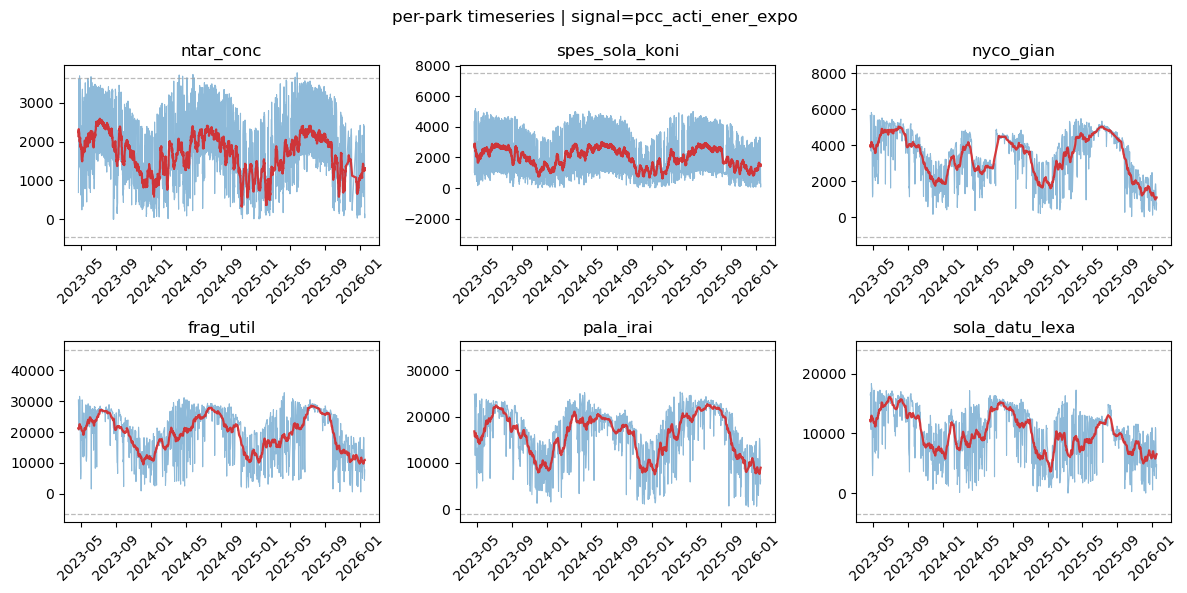

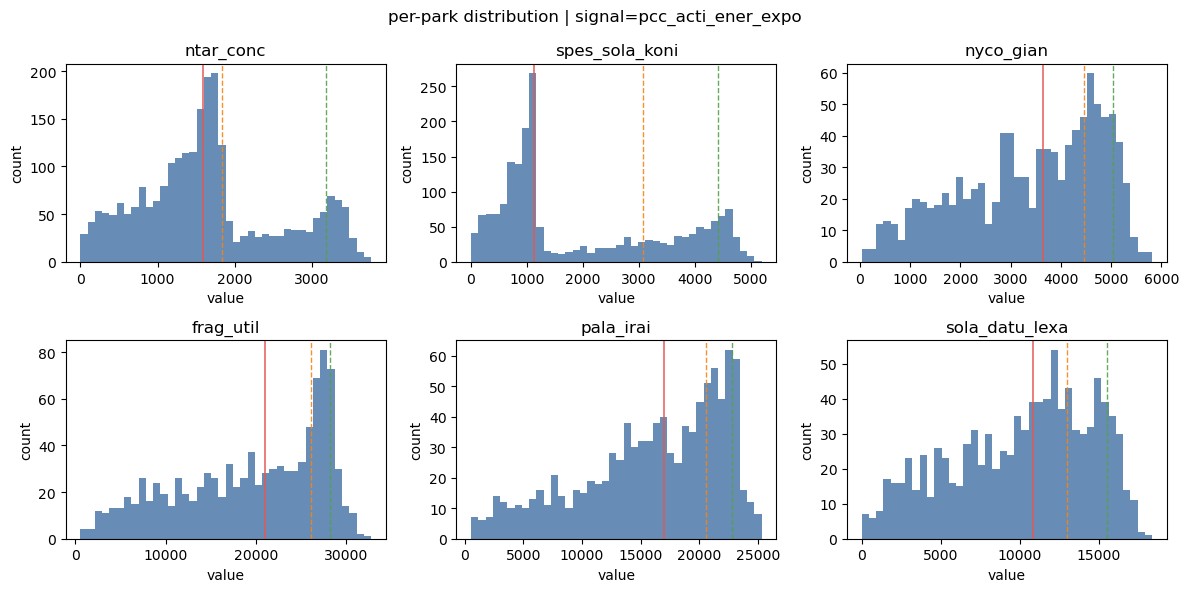

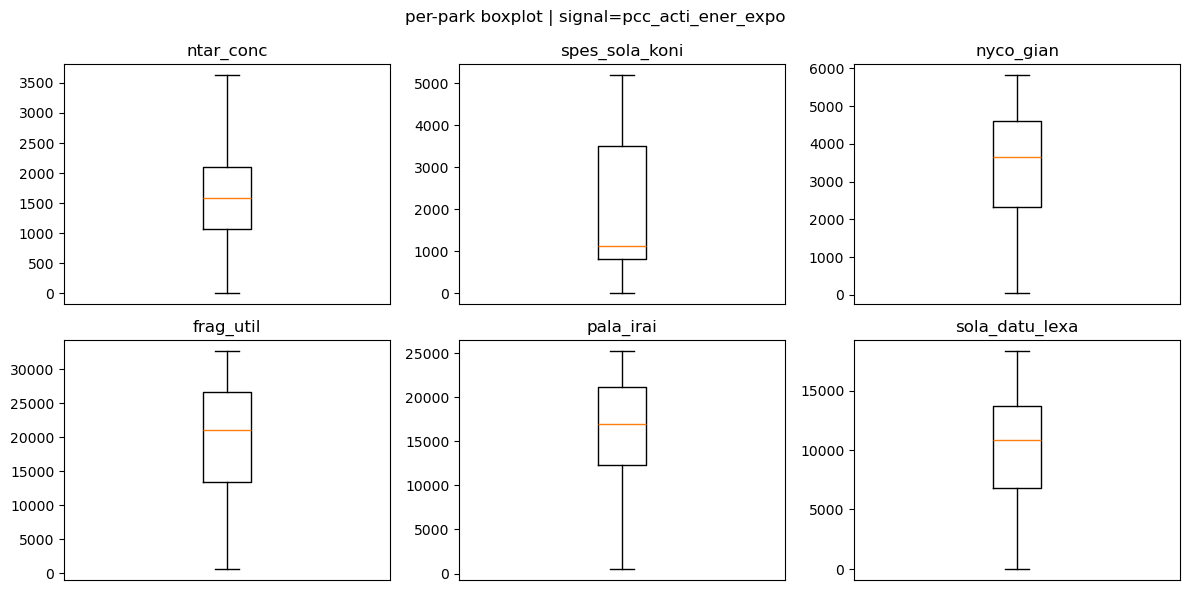

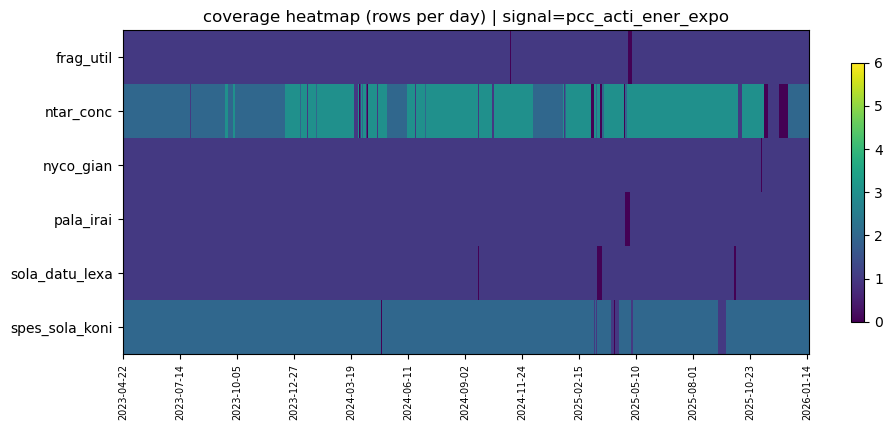

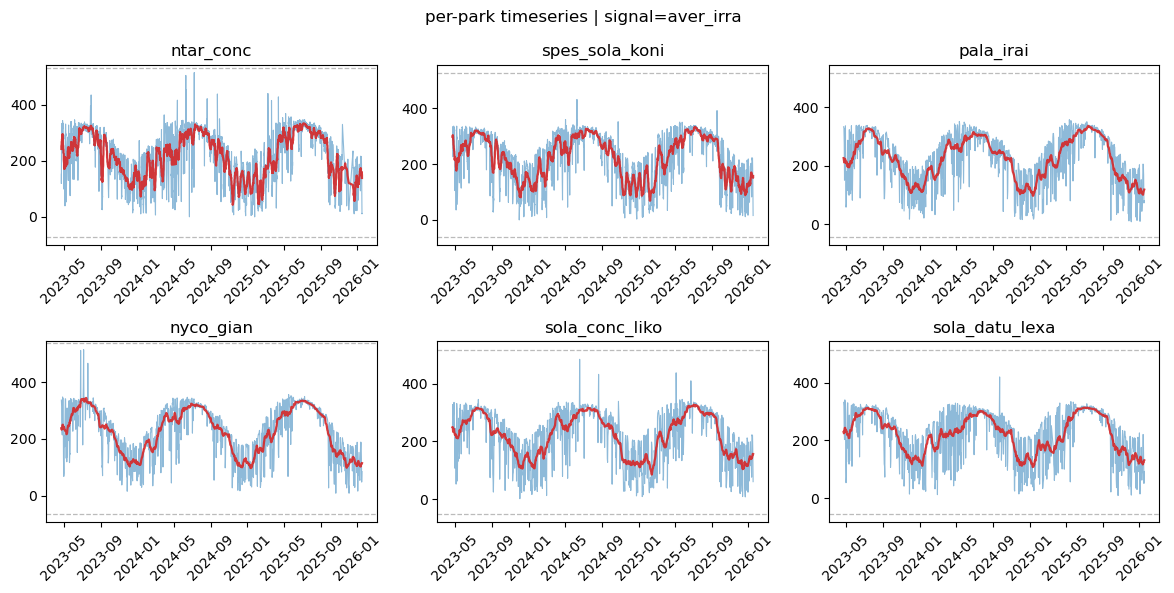

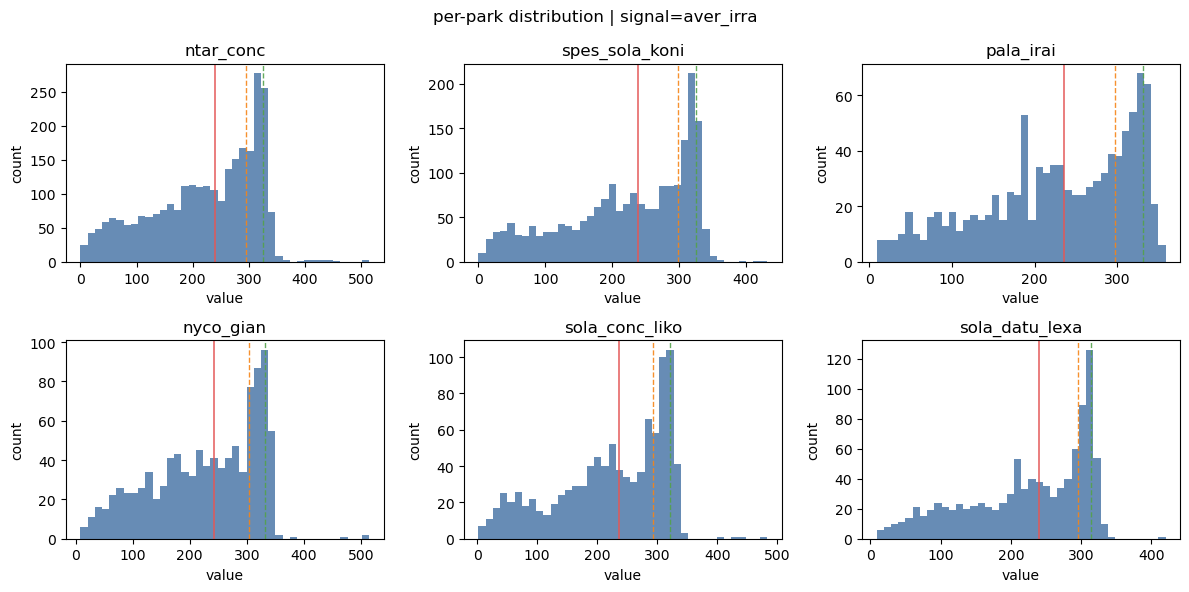

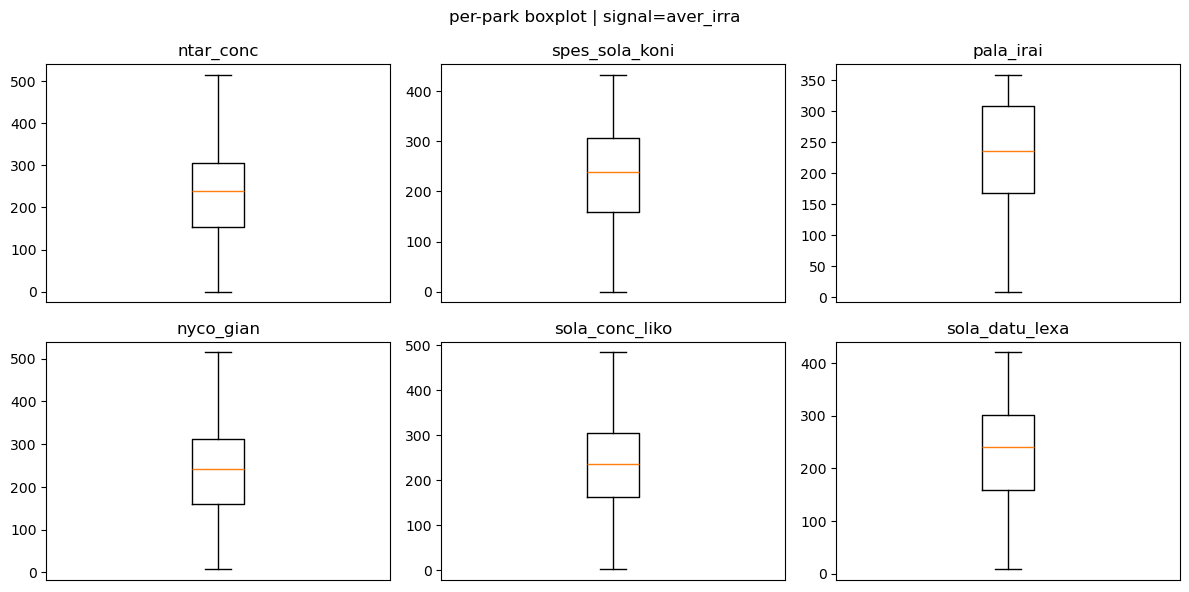

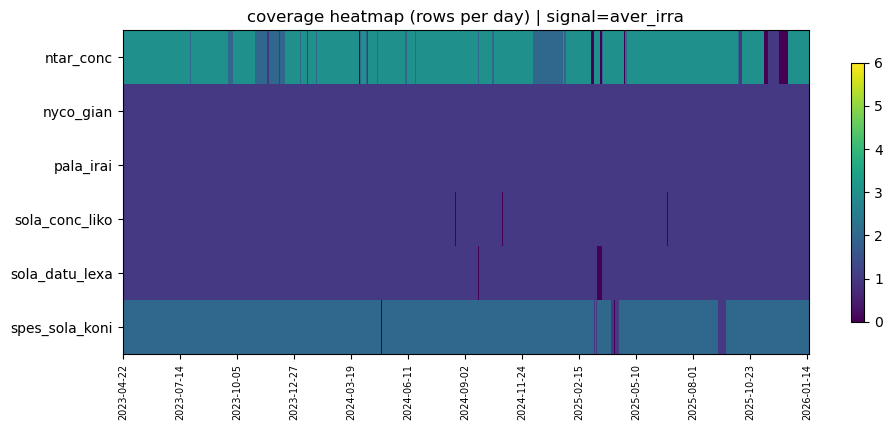

In [10]:
from pathlib import Path
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from src import silver_pre_ingestion_eda as spie
importlib.reload(spie)

stage_dir = WORKSPACE_ROOT / "outputs" / "silver_stage"
stage_path = globals().get("stage_path")
if stage_path:
    stage_path = Path(stage_path)

if not stage_path or not stage_path.exists():
    if stage_dir.exists():
        candidates = sorted(stage_dir.glob("*.parquet"), key=lambda p: p.stat().st_mtime, reverse=True)
        stage_path = candidates[0] if candidates else None

if stage_path and Path(stage_path).exists():
    df_stage = pd.read_parquet(stage_path)
    eda_outputs = spie.run_silver_pre_ingestion_eda(
        df_stage,
        spie.EdaConfig(
            plot_kinds=["timeseries", "hist", "box", "coverage"],
            max_days=1000,  # Filter to last 50 days (applies to ALL plots/stats)
            max_parks=6,  # Show 6 parks per signal grid
            max_signals=2,  # Plot only 2 most common signals (all 4 plot types each)
            # focus_signal="pcc_acti_energy_expo",  # Uncomment to plot specific signal
            # focus_signals=["aver_irra", "pcc_acti_energy_expo"],  # Or multiple signals
        )
    )
    print(eda_outputs["overview"])
    display(eda_outputs["unit_stats"].head())
    display(eda_outputs["signal_stats"].head())
    display(eda_outputs["coverage"].head())
    for fig in eda_outputs["plots"]:
        display(fig)
        plt.close(fig)
else:
    print("No staged parquet found; run silver prep staging first.")


## Silver EDA (Exploratory Data Analysis)


**Plot control parameters:**
- `max_days`: Filter data to last N days (applies to ALL plots and statistics)
- `max_signals`: Limits how many signals to plot (default=12, plots all 4 plot types for each)
- `max_parks`: Limits parks per signal grid (default=6, None = all parks)
- `focus_signal`: Plot only one specific signal (overrides max_signals)
- `focus_signals`: Plot only specific signals list (overrides max_signals)
- `plot_kinds`: Types of plots to generate (timeseries, hist, box, coverage)


In [ ]:
# Export park column names to CSV
output_path = WORKSPACE_ROOT / "outputs" / "park_columns.csv"
output_path.parent.mkdir(exist_ok=True)

# Create DataFrame with park names
park_cols_df = pd.DataFrame({
    'park_name': _park_cols
})

# Save to CSV
park_cols_df.to_csv(output_path, index=False)
print(f"✓ Exported {len(_park_cols)} park columns to: {output_path}")
print(f"\nFirst 10 parks:")
print(park_cols_df.head(10))

In [ ]:
def extract_park_name_before_pcc(col: str) -> str:
    """
    Extract park name and capacity, stopping before 'PCC'.
    
    Examples:
    - '[Park_A_100_kWp_PCC_PCC_active_energy]' → 'Park_A_100_kWp'
    - '[Park_B_200_kWp_Location]' → 'Park_B_200_kWp_Location'
    """
    import re
    # Remove brackets
    clean = col.replace('[', '').replace(']', '').strip()
    # Split at first PCC and take the part before it
    parts = clean.split('_PCC')
    if parts:
        return parts[0]
    return clean

In [ ]:
def select_columns_if_all_from_text_in_list(
    columns: list[str],
    text_list: list[str]
) -> list[str]:
    """
    Select columns that contain all specified texts from a list.
    
    Parameters
    ----------
    columns : list[str]
        List of column names to filter
    text_list : list[str]
        List of texts that must all be present in a column name
    
    Returns
    -------
    list[str]
        Filtered list of column names containing all specified texts
    """
    selected_cols = []
    for col in columns:
        if all(text.lower() in col.lower() for text in text_list):
            selected_cols.append(col)
    return selected_cols

In [ ]:
daily_historical = daily_historical[select_columns_if_all_from_text_in_list(daily_historical.columns, ['energy_exp'])]

In [ ]:
def lineplot_timeseries_per_column(
    df: pd.DataFrame,
    title_prefix: str = "Time Series",
    ylabel: str = "Value",
    ncols: int = 3,
    sharex: bool = True,
    sharey: bool = False,
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Plot one line chart per column in a grid of subplots and optionally save the figure.

    Parameters:
    -----------
    df: pd.DataFrame
        Date-indexed DataFrame; each column is a park/series.
    title_prefix: str
        Prefix used in subplot titles and default filename.
    ylabel: str
        Y-axis label for all subplots (default: "Value").
    ncols: int
        Number of columns in the subplot grid.
    sharex/sharey: bool
        Share axes across subplots.
    save: bool
        If True, saves the figure.
    save_dir: str | Path | None
        Directory where the figure will be saved. If None and `save=True`,
        pass a directory explicitly (e.g., PLOTS_DIR) or it will fallback to CWD/"plots".
    base_filename: str | None
        Base filename without extension; if None, derived from title_prefix.
    dpi: int
        Resolution for the saved image.
    fmt: str
        File format for saving (e.g., "png", "pdf", "svg").
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    cols = list(df.columns)
    if len(cols) == 0:
        print("No columns to plot.")
        return None

    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    figsize = (min(6 * ncols, 24), max(2.8 * nrows, 4))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=sharex, sharey=sharey)
    if nrows == 1:
        axes = np.array([axes])
    if ncols == 1:
        axes = axes.reshape(nrows, 1)

    axes_flat = axes.ravel()

    for i, col in enumerate(cols):
        ax = axes_flat[i]
        ax.plot(df.index, df[col], linewidth=1.2)
        try:
            label = extract_park_name_before_pcc(col)
        except Exception:
            label = col
        ax.set_title(f"{title_prefix}: {label}")
        ax.grid(alpha=0.3)
        ax.set_xlabel("Date")
        ax.set_ylabel(ylabel)

    for j in range(len(cols), len(axes_flat)):
        axes_flat[j].set_visible(False)

    for ax in axes_flat[:len(cols)]:
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha('right')

    plt.tight_layout()

    # Use shared save utility
    saved_path = save_figure(
        fig=fig,
        title_prefix=title_prefix,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )

    plt.show()
    return saved_path

_ = lineplot_timeseries_per_column(
    daily_historical,
    title_prefix="Daily Energy",
    ylabel="Energy [kWh]",
    ncols=3,
    sharex=True,
    sharey=False,
    save=True,
    save_dir=PLOTS_DIR / "weekly_analysis",
    base_filename="daily_energy_timeseries_grid",
    dpi=180,
    fmt="png",
)

In [ ]:
def histplot_distribution_per_column(
    df: pd.DataFrame,
    title_prefix: str = "Distribution",
    xlabel: str = "Value",
    ncols: int = 3,
    bins: int = 30,
    density: bool = False,
    dropna: bool = True,
    sharex: bool = False,
    sharey: bool = False,
    show_stats: bool = True,
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Plot one histogram per column in a grid of subplots and optionally save the figure.

    Parameters:
    -----------
    df: pd.DataFrame
        DataFrame indexed by date; each column is a park/series.
    title_prefix: str
        Prefix used in subplot titles and default filename.
    xlabel: str
        X-axis label for all subplots (default: "Value").
    ncols: int
        Number of columns in the subplot grid.
    bins: int
        Histogram bin count.
    density: bool
        If True, normalize histogram to form a probability density.
    dropna: bool
        If True, exclude NaNs from each column.
    sharex/sharey: bool
        Share axes across subplots.
    show_stats: bool
        If True, draw vertical lines for mean and median.
    save: bool
        If True, saves the figure.
    save_dir: str | Path | None
        Directory where the figure will be saved. If None and `save=True`,
        pass a directory explicitly (e.g., PLOTS_DIR) or it will fallback to CWD/"plots".
    base_filename: str | None
        Base filename without extension; if None, derived from title_prefix.
    dpi: int
        Resolution for the saved image.
    fmt: str
        File format for saving (e.g., "png", "pdf", "svg").
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    cols = list(df.columns)
    if len(cols) == 0:
        print("No columns to plot.")
        return None

    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    figsize = (min(6 * ncols, 24), max(2.8 * nrows, 4))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=sharex, sharey=sharey)
    if nrows == 1:
        axes = np.array([axes])
    if ncols == 1:
        axes = axes.reshape(nrows, 1)

    axes_flat = axes.ravel()

    for i, col in enumerate(cols):
        ax = axes_flat[i]
        values = df[col]
        if dropna:
            values = values.dropna()

        ax.hist(values, bins=bins, alpha=0.75, color='steelblue', edgecolor='white', density=density)

        try:
            label = extract_park_name_before_pcc(col)
        except Exception:
            label = col
        ax.set_title(f"{title_prefix}: {label}")
        ax.grid(axis='y', alpha=0.3)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Density" if density else "Count")

        if show_stats and len(values) > 0:
            mean_val = float(values.mean())
            median_val = float(values.median())
            ax.axvline(mean_val, color='orange', linestyle='--', linewidth=1, label='Mean')
            ax.axvline(median_val, color='crimson', linestyle='--', linewidth=1, label='Median')
            ax.legend(fontsize=8)

    # Hide any unused axes
    for j in range(len(cols), len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.tight_layout()

    # Use shared save utility
    saved_path = save_figure(
        fig=fig,
        title_prefix=title_prefix,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )

    plt.show()
    return saved_path

# Example: plot one histogram per column
_ = histplot_distribution_per_column(
    daily_historical,
    title_prefix="Daily Energy Distribution",
    xlabel="Energy [kWh]",
    ncols=3,
    bins=40,
    density=False,
    save=False,
    save_dir=PLOTS_DIR,
    base_filename="daily_energy_hist_grid",
    dpi=180,
    fmt="png",
)

In [ ]:
def compute_descriptive_statistics(
    df: pd.DataFrame,
    round_digits: int = 2,
    cmap: str = "Blues",
    sort_by: str | None = "Mean",
    ascending: bool = False,
    top_n: int | None = None,
    show: bool = True,
):
    """
    Compute and display descriptive statistics with a styled, visual summary.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame indexed by date; columns are series/parks.
    round_digits : int
        Number of decimal places for numeric formatting.
    cmap : str
        Colormap name for background gradients.
    sort_by : str | None
        Optional column to sort by (e.g., "Mean", "Median", "Missing %").
    ascending : bool
        Sort ascending or descending when `sort_by` is provided.
    top_n : int | None
        If provided, display only the top N rows after sorting.
    show : bool
        If True, renders a styled table; otherwise returns the (stats, styler).

    Returns
    -------
    pd.DataFrame | tuple[pd.DataFrame, pd.io.formats.style.Styler]
    """
    import numpy as np
    from IPython.display import display

    # Base descriptive stats
    desc = df.describe(percentiles=[0.25, 0.5, 0.75]).T

    # Additional metrics
    median = df.median()
    var = df.var()
    skew = df.skew()
    kurt = df.kurtosis()

    missing_count = df.isna().sum()
    total_rows = df.shape[0]
    missing_pct = (missing_count / total_rows * 100.0).replace([np.inf, -np.inf], np.nan)

    non_nan_count = df.notna().sum()
    zero_count = df.eq(0).sum()
    zero_pct = (zero_count / non_nan_count * 100.0).replace([np.inf, -np.inf], np.nan)

    # Assemble
    stats = pd.DataFrame({
        "Count": desc["count"],
        "Missing Count": missing_count,
        "Missing %": missing_pct,
        "Zero Count": zero_count,
        "Zero %": zero_pct,
        "Mean": desc["mean"],
        "Median": median,
        "Std": desc["std"],
        "Variance": var,
        "Skew": skew,
        "Kurtosis": kurt,
        "Min": desc["min"],
        "Q1 (25%)": desc["25%"],
        "Q3 (75%)": desc["75%"],
        "Max": desc["max"],
    })

    # Optional sort and limit
    if sort_by is not None and sort_by in stats.columns:
        stats = stats.sort_values(by=sort_by, ascending=ascending)
    if top_n is not None and top_n > 0:
        stats = stats.head(top_n)

    # Round for display
    stats_rounded = stats.round(round_digits)

    # Build a Styler with visual cues
    subset_gradient = [
        "Mean", "Median", "Std", "Variance", "Skew", "Kurtosis", "Min", "Q1 (25%)", "Q3 (75%)", "Max"
    ]
    subset_bar = ["Missing %", "Zero %"]

    styler = (
        stats_rounded.style
        .set_caption("Descriptive Statistics per Series")
        .background_gradient(cmap=cmap, subset=[c for c in subset_gradient if c in stats_rounded.columns])
        .bar(subset=[c for c in subset_bar if c in stats_rounded.columns], color="#FDAE61")
        .format(precision=round_digits)
        .set_table_styles([
            {"selector": "th.col_heading", "props": "text-align: center;"},
            {"selector": "th.row_heading", "props": "text-align: left;"},
            {"selector": "caption", "props": "caption-side: top; font-weight: bold; font-size: 1.1em;"},
        ])
        .set_properties(**{"text-align": "right"})
    )

    if show:
        display(styler)
        return stats
    else:
        return stats, styler

# Render styled stats by default
_ = compute_descriptive_statistics(daily_historical, round_digits=2, cmap="Blues", sort_by="Missing %", ascending=False)


In [ ]:
def barplot_nan_count(
    df: pd.DataFrame,
    title: str = "NaN Count per Column",
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Create a bar plot showing the count and percentage of NaN values for each column.
    
    Parameters:
    -----------
    df: pd.DataFrame
        The dataframe to analyze
    title: str
        Plot title
    save: bool
        If True, saves the figure
    save_dir: str | Path | None
        Directory where the figure will be saved. If None and `save=True`,
        pass a directory explicitly (e.g., PLOTS_DIR) or it will fallback to CWD/"plots".
    base_filename: str | None
        Base filename without extension; if None, derived from title.
    dpi: int
        Resolution for the saved image.
    fmt: str
        File format for saving (e.g., "png", "pdf", "svg").
    """
    nan_counts = df.isna().sum()
    nan_pcts = (df.isna().sum() / len(df)) * 100
    
    # Sort by count descending
    nan_counts = nan_counts.sort_values(ascending=False)
    nan_pcts = nan_pcts[nan_counts.index]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot of counts
    ax1.bar(range(len(nan_counts)), nan_counts.values, color='steelblue', alpha=0.7)
    ax1.set_xticks(range(len(nan_counts)))
    ax1.set_xticklabels([extract_park_name_before_pcc(col) for col in nan_counts.index], rotation=45, ha='right')
    ax1.set_ylabel("NaN Count")
    ax1.set_xlabel("PV Parks")
    ax1.set_title(f"{title} - Counts")
    ax1.grid(axis='y', alpha=0.3)
    
    # Bar plot of percentages
    ax2.bar(range(len(nan_pcts)), nan_pcts.values, color='coral', alpha=0.7)
    ax2.set_xticks(range(len(nan_pcts)))
    ax2.set_xticklabels([extract_park_name_before_pcc(col) for col in nan_pcts.index], rotation=45, ha='right')
    ax2.set_ylabel("NaN Percentage (%)")
    ax2.set_xlabel("PV Parks")
    ax2.set_title(f"{title} - Percentages")
    ax2.grid(axis='y', alpha=0.3)
    ax2.axhline(y=50, color='red', linestyle='--', linewidth=1, label='50% threshold')
    ax2.legend()
    
    plt.tight_layout()
    
    # Use shared save utility
    saved_path = save_figure(
        fig=fig,
        title_prefix=title,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )
    
    plt.show()
    
    return nan_counts, nan_pcts, saved_path

nan_counts, nan_pcts, saved_path = barplot_nan_count(
    daily_historical,
    "NaN Analysis for Daily Data",
    save=False,
    save_dir=PLOTS_DIR,
    base_filename="nan_analysis_daily",
    dpi=180,
    fmt="png",
)
print(f"\nTotal columns: {len(daily_historical.columns)}")
print(f"Columns with NaN: {(nan_counts > 0).sum()}")
print(f"Columns with >50% NaN: {(nan_pcts > 50).sum()}")
if saved_path:
    print(f"✓ Figure saved to: {saved_path}")

In [ ]:
def detect_problematic_columns(df: pd.DataFrame, nan_threshold: float = 0.5, zero_threshold: float = 0.8) -> dict:
    """
    Detect columns that are mostly NaN, missing, or zeros.
    
    Parameters:
    -----------
    df: pd.DataFrame
        The dataframe to analyze
    nan_threshold: float
        Fraction of NaN/missing values above which a column is flagged (default: 0.5 = 50%)
    zero_threshold: float
        Fraction of zero values (among non-NaN) above which a column is flagged (default: 0.8 = 80%)
    
    Returns:
    --------
    dict with keys:
        - 'mostly_nan': list of columns with high NaN percentage
        - 'mostly_zero': list of columns with high zero percentage
        - 'summary': DataFrame with statistics for each column
    """
    results = {
        'mostly_nan': [],
        'mostly_zero': [],
        'summary': []
    }
    
    for col in df.columns:
        total_count = len(df[col])
        nan_count = df[col].isna().sum()
        nan_pct = nan_count / total_count if total_count > 0 else 0
        
        # For zero detection, only consider non-NaN values
        non_nan_values = df[col].dropna()
        non_nan_count = len(non_nan_values)
        
        if non_nan_count > 0:
            zero_count = (non_nan_values == 0).sum()
            zero_pct = zero_count / non_nan_count
        else:
            zero_count = 0
            zero_pct = 0
        
        # Store summary
        results['summary'].append({
            'column': col,
            'total_rows': total_count,
            'nan_count': nan_count,
            'nan_pct': nan_pct,
            'non_nan_count': non_nan_count,
            'zero_count': zero_count,
            'zero_pct': zero_pct,
        })
        
        # Flag problematic columns
        if nan_pct >= nan_threshold:
            results['mostly_nan'].append(col)
        
        if zero_pct >= zero_threshold:
            results['mostly_zero'].append(col)
    
    results['summary'] = pd.DataFrame(results['summary'])
    
    return results

# Example usage
problematic = detect_problematic_columns(daily_historical, nan_threshold=0.5, zero_threshold=0.8)

print("=== Columns with mostly NaN (≥50%) ===")
if problematic['mostly_nan']:
    for col in problematic['mostly_nan']:
        stats = problematic['summary'][problematic['summary']['column'] == col].iloc[0]
        print(f"  {col}: {stats['nan_pct']*100:.1f}% NaN ({stats['nan_count']}/{stats['total_rows']})")
else:
    print("  None found")

print("\n=== Columns with mostly zeros (≥80% of non-NaN) ===")
if problematic['mostly_zero']:
    for col in problematic['mostly_zero']:
        stats = problematic['summary'][problematic['summary']['column'] == col].iloc[0]
        print(f"  {col}: {stats['zero_pct']*100:.1f}% zeros ({stats['zero_count']}/{stats['non_nan_count']} non-NaN)")
else:
    print("  None found")

print("\n=== Summary Statistics ===")
print(problematic['summary'][['column', 'nan_pct', 'zero_pct']].to_string(index=False))


In [ ]:
def plot_boxplot(
    mat: pd.DataFrame,
    title: str,
    ylabel: str = "Production [kWh]",
    ylim=None,
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Create boxplots for each park showing the distribution of values across all dates.
    
    Parameters:
    -----------
    mat: pd.DataFrame
        Date x park dataframe with values to plot
    title: str
        Plot title
    ylabel: str
        Y-axis label (default: "Production [kWh]")
    ylim: tuple or None
        Y-axis limits as (min, max)
    save: bool
        If True, saves the figure
    save_dir: str | Path | None
        Directory where the figure will be saved. If None and `save=True`,
        pass a directory explicitly (e.g., PLOTS_DIR) or it will fallback to CWD/"plots".
    base_filename: str | None
        Base filename without extension; if None, derived from title.
    dpi: int
        Resolution for the saved image.
    fmt: str
        File format for saving (e.g., "png", "pdf", "svg").
    """
    # Prepare data - we want boxplots for each park (column)
    data_list = []
    labels = []
    
    for col in mat.columns:
        # Get non-NaN values for this park
        values = mat[col].dropna()
        if len(values) > 0:
            data_list.append(values)
            labels.append(f"{extract_park_name_before_pcc(col)}\n({parse_kwp_from_header(col):.0f} kWp)")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(max(12, 0.8 * len(labels)), 6))
    
    bp = ax.boxplot(data_list, labels=labels, patch_artist=True, showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red', markeredgecolor='red', markersize=5))
    
    # Customize box colors
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel("PV Parks", fontsize=12)
    
    # Rotate x labels if many parks
    if len(labels) > 10:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    # Use shared save utility
    saved_path = save_figure(
        fig=fig,
        title_prefix=title,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )
    
    plt.show()
    
    return saved_path

plot_boxplot(daily_historical, title="Daily Boxplot", save=True, save_dir=PLOTS_DIR / "weekly_analysis", 
             base_filename="daily_boxplot", dpi=180, fmt="png")

In [ ]:
def detect_outliers_iqr(df: pd.DataFrame, multiplier: float = 1.5) -> dict:
    """
    Detect outliers using the Interquartile Range (IQR) method.
    
    Parameters:
    -----------
    df: pd.DataFrame
        The dataframe to analyze
    multiplier: float
        IQR multiplier for outlier detection (default: 1.5)
        - 1.5 is standard for outliers
        - 3.0 is often used for extreme outliers
    
    Returns:
    --------
    dict with keys:
        - 'outlier_counts': Series with count of outliers per column
        - 'outlier_pcts': Series with percentage of outliers per column
        - 'outlier_mask': DataFrame with True for outliers, False otherwise
        - 'bounds': DataFrame with lower_bound and upper_bound per column
        - 'summary': DataFrame with statistics for each column
    """
    results = {
        'outlier_counts': {},
        'outlier_pcts': {},
        'outlier_mask': pd.DataFrame(index=df.index),
        'bounds': [],
        'summary': []
    }
    
    for col in df.columns:
        # Skip columns with insufficient non-NaN values
        non_nan_values = df[col].dropna()
        if len(non_nan_values) < 4:
            results['outlier_counts'][col] = 0
            results['outlier_pcts'][col] = 0.0
            results['outlier_mask'][col] = False
            results['bounds'].append({
                'column': col,
                'lower_bound': np.nan,
                'upper_bound': np.nan,
                'Q1': np.nan,
                'Q3': np.nan,
                'IQR': np.nan
            })
            continue
        
        # Calculate quartiles and IQR
        Q1 = non_nan_values.quantile(0.25)
        Q3 = non_nan_values.quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate bounds
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # Detect outliers
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_count = outlier_mask.sum()
        outlier_pct = (outlier_count / len(non_nan_values)) * 100 if len(non_nan_values) > 0 else 0
        
        results['outlier_counts'][col] = outlier_count
        results['outlier_pcts'][col] = outlier_pct
        results['outlier_mask'][col] = outlier_mask
        
        results['bounds'].append({
            'column': col,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR
        })
        
        results['summary'].append({
            'column': col,
            'total_values': len(df[col]),
            'non_nan_values': len(non_nan_values),
            'outlier_count': outlier_count,
            'outlier_pct': outlier_pct,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
        })
    
    results['outlier_counts'] = pd.Series(results['outlier_counts'])
    results['outlier_pcts'] = pd.Series(results['outlier_pcts'])
    results['bounds'] = pd.DataFrame(results['bounds'])
    results['summary'] = pd.DataFrame(results['summary'])
    
    return results

# Detect outliers in the daily dataframe
outliers = detect_outliers_iqr(daily_historical, multiplier=1.5)

print("=== Outlier Detection Summary (IQR method) ===")
print(f"Total columns analyzed: {len(daily_historical.columns)}")
print(f"Columns with outliers: {(outliers['outlier_counts'] > 0).sum()}")
print(f"\nTop 10 columns with most outliers:")
top_outliers = outliers['summary'].sort_values('outlier_count', ascending=False).head(10)
print(top_outliers[['column', 'outlier_count', 'outlier_pct', 'lower_bound', 'upper_bound']].to_string(index=False))

In [ ]:
def visualize_outliers(outliers_result: dict, title_suffix: str = "IQR Method"):
    """
    Visualize outlier detection results with bar plots.
    
    Parameters:
    -----------
    outliers_result: dict
        Result dictionary from detect_outliers_iqr function
    title_suffix: str
        Suffix to add to plot titles (default: "IQR Method")
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot of outlier counts
    sorted_counts = outliers_result['outlier_counts'].sort_values(ascending=False)
    ax1.bar(range(len(sorted_counts)), sorted_counts.values, color='crimson', alpha=0.7)
    ax1.set_xticks(range(len(sorted_counts)))
    ax1.set_xticklabels([extract_park_name_before_pcc(col) for col in sorted_counts.index], rotation=45, ha='right')
    ax1.set_ylabel("Outlier Count")
    ax1.set_xlabel("PV Parks")
    ax1.set_title(f"Outlier Count per Column ({title_suffix})")
    ax1.grid(axis='y', alpha=0.3)
    
    # Bar plot of outlier percentages
    sorted_pcts = outliers_result['outlier_pcts'].sort_values(ascending=False)
    ax2.bar(range(len(sorted_pcts)), sorted_pcts.values, color='orange', alpha=0.7)
    ax2.set_xticks(range(len(sorted_pcts)))
    ax2.set_xticklabels([extract_park_name_before_pcc(col) for col in sorted_pcts.index], rotation=45, ha='right')
    ax2.set_ylabel("Outlier Percentage (%)")
    ax2.set_xlabel("PV Parks")
    ax2.set_title(f"Outlier Percentage per Column ({title_suffix})")
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize the outliers
visualize_outliers(outliers, title_suffix="IQR Method, multiplier=1.5")

In [ ]:
# CREATE METADATA WITH ACTUAL COORDINATES
# Replace this cell with your actual park metadata
# Expected columns: park_name, lat, lon, kwp, loss_pct, timezone

# OPTION 1: Load from CSV file with actual coordinates
# meta = pd.read_csv(WORKSPACE_ROOT / "data" / "park_metadata.csv")
# Required columns: park_name (matching park_cols), lat, lon, kwp, loss_pct, timezone

# OPTION 2: Create manually for each park
# Example structure:
park_cols = daily_historical.columns.tolist()
meta_data = {
    'park_name': park_cols,
    'latitude': [
    38.39,
    37.61,
    38.31,
    38.10,
    37.94,
    38.31,
    38.31,
    38.31,
    38.31,
    38.31,
    38.02,
    37.95,
    38.39,
    37.94,
    37.95,
    38.31,
    37.94,
    38.30,
    37.95,
    38.29,
    37.89,
    38.30
],  # REPLACE with actual latitudes
    'longitude': [
    23.47,
    21.89,
    23.24,
    21.65,
    21.30,
    23.24,
    23.24,
    23.24,
    23.24,
    23.24,
    21.40,
    21.29,
    23.47,
    21.30,
    21.29,
    23.24,
    21.30,
    23.24,
    21.29,
    23.29,
    21.27,
    23.28
],  # REPLACE with actual longitudes
    'kwp': [parse_kwp_from_header(col) for col in park_cols],  # Extracted from column names
    'loss_pct': [18.0] * len(park_cols),  # System losses (adjust per park if needed)
    'timezone': ['Europe/Athens'] * len(park_cols)
}
meta = pd.DataFrame(meta_data)

# Validate metadata
print(f"Metadata created for {len(meta)} parks")
print(f"Park columns count: {len(park_cols)}")
print(f"\nValidation:")
print(f"  - Latitudes: {len(meta['latitude'])} values")
print(f"  - Longitudes: {len(meta['longitude'])} values")
print(f"  - All parks matched: {len(meta) == len(park_cols)}")

# Check if all park names match
if set(meta['park_name']) != set(park_cols):
    missing_in_meta = set(park_cols) - set(meta['park_name'])
    extra_in_meta = set(meta['park_name']) - set(park_cols)
    if missing_in_meta:
        print(f"\n⚠️  WARNING: Parks missing in metadata: {len(missing_in_meta)}")
        print(f"   First few: {list(missing_in_meta)[:3]}")
    if extra_in_meta:
        print(f"\n⚠️  WARNING: Extra parks in metadata: {len(extra_in_meta)}")
else:
    print(f"  ✓ All park names match!")

meta.set_index('park_name', inplace=True)

print(f"\nSample metadata:")
print(meta.head(10))
print(f"\n✓ Using actual coordinates from Greece")


In [ ]:
# # Reload the module to pick up the fix
# importlib.reload(pvgis_pi_heatmap)
# from src.pvgis_pi_heatmap import compute_pi_anomaly

# Recompute with the fixed function
pi_fixed, score_fixed, flag_fixed = compute_pi_anomaly(
    daily_df=daily_historical,
    meta=meta,
    cache_dir=CACHE_DIR,
    pvgis_url="https://re.jrc.ec.europa.eu/api/",
)

print("\nFixed PI data info:")
print(f"  Total rows: {len(pi_fixed)}")
print(f"  Non-NaN rows: {pi_fixed.notna().any(axis=1).sum()}")
print(f"  First non-NaN date: {pi_fixed[pi_fixed.notna().any(axis=1)].index.min() if pi_fixed.notna().any(axis=1).any() else 'None'}")
print(f"  Last non-NaN date: {pi_fixed[pi_fixed.notna().any(axis=1)].index.max() if pi_fixed.notna().any(axis=1).any() else 'None'}")
print(f"\nData after 2024-12-31:")
pi_2025plus = pi_fixed[pi_fixed.index > '2024-12-31']
print(f"  Rows: {len(pi_2025plus)}")
print(f"  Non-NaN values: {pi_2025plus.notna().sum().sum()}")

# Update the main variables
pi = pi_fixed
score = score_fixed
flag = flag_fixed

In [ ]:
print("Daily data date range:")
print(f"  Start: {daily_historical.index.min()}")
print(f"  End: {daily_historical.index.max()}")
print(f"  Years: {daily_historical.index.min().year} to {daily_historical.index.max().year}")
print(f"\nPI data info:")
print(f"  Total rows: {len(pi)}")
print(f"  Non-NaN rows: {pi.notna().any(axis=1).sum()}")
print(f"  First non-NaN date: {pi[pi.notna().any(axis=1)].index.min() if pi.notna().any(axis=1).any() else 'None'}")
print(f"  Last non-NaN date: {pi[pi.notna().any(axis=1)].index.max() if pi.notna().any(axis=1).any() else 'None'}")
print(f"\nData after 2024-01-01:")
pi_2024plus = pi[pi.index >= '2024-01-01']
print(f"  Rows: {len(pi_2024plus)}")
print(f"  Non-NaN values: {pi_2024plus.notna().sum().sum()}")

In [ ]:
def plot_heatmap(
    mat: pd.DataFrame,
    title: str,
    vmin=None,
    vmax=None,
    start_date=None,
    end_date=None,
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Plot a heatmap of date x park data.
    
    Parameters:
    -----------
    mat: pd.DataFrame
        Date x park dataframe with values to plot
    title: str
        Plot title
    vmin: float or None
        Minimum value for colormap
    vmax: float or None
        Maximum value for colormap
    start_date: str or pd.Timestamp or None
        Start date for filtering (inclusive). Format: 'YYYY-MM-DD' or any pandas-compatible date
    end_date: str or pd.Timestamp or None
        End date for filtering (inclusive). Format: 'YYYY-MM-DD' or any pandas-compatible date
    save: bool
        If True, saves the figure
    save_dir: str | Path | None
        Directory where the figure will be saved. If None and `save=True`,
        pass a directory explicitly (e.g., PLOTS_DIR) or it will fallback to CWD/"plots".
    base_filename: str | None
        Base filename without extension; if None, derived from title.
    dpi: int
        Resolution for the saved image.
    fmt: str
        File format for saving (e.g., "png", "pdf", "svg").
    """
    # Filter by date range if specified
    if start_date is not None or end_date is not None:
        if start_date is not None:
            start_date = pd.to_datetime(start_date)
            mat = mat[mat.index >= start_date]
        if end_date is not None:
            end_date = pd.to_datetime(end_date)
            mat = mat[mat.index <= end_date]
        
        if len(mat) == 0:
            print(f"Warning: No data found in the specified date range")
            return None
    
    # mat: date x park -> we plot parks x dates
    m = mat.T.copy()

    # nicer y labels (park label + kWp)
    y = []
    for col in m.index:
        y.append(f"{extract_park_name_before_pcc(col)} ({parse_kwp_from_header(col):.0f} kWp)")
    m.index = y

    fig, ax = plt.subplots(figsize=(14, max(6, 0.28 * len(m.index))))
    im = ax.imshow(m.values, aspect="auto", interpolation="nearest", cmap="turbo", vmin=vmin, vmax=vmax)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_yticks(np.arange(len(m.index)))
    ax.set_yticklabels(m.index, fontsize=10)

    dates = pd.to_datetime(m.columns)
    step = max(1, len(dates) // 12)
    xticks = np.arange(0, len(dates), step)
    ax.set_xticks(xticks)
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in dates[::step]], rotation=45, ha="right")

    # Disable grid lines (they can appear as lines over the heatmap)
    ax.grid(False)

    cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
    cbar.ax.set_ylabel("KPI", rotation=90, fontsize=10)
    plt.tight_layout()
    
    # Use shared save utility
    saved_path = save_figure(
        fig=fig,
        title_prefix=title,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )
    
    plt.show()
    
    return saved_path

# Examples showing KPI data
plot_heatmap(pi, "PI_PVGIS = Measured / PVGIS expected", vmin=0.0, vmax=1.5,
             save=True, save_dir=PLOTS_DIR / "weekly_analysis", base_filename="heatmap_pi", dpi=180, fmt="png")
plot_heatmap(score, "Robust anomaly score (rolling median/MAD)", vmin=-6, vmax=6,
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_score", dpi=180, fmt="png")
plot_heatmap(flag, "Flags (-1 low, 0 ok, +1 high)", vmin=-1, vmax=1,
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_flag", dpi=180, fmt="png")

In [ ]:
# Plot actual generation data with date filtering
plot_heatmap(daily_historical, "Daily Generation [kWh/day]", vmin=None, vmax=None,
             start_date='2026-01-01', end_date='2026-01-31',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_daily_jan2026", dpi=180, fmt="png")

# Example: Filter heatmap to show only specific date ranges
# Show only January 2026
plot_heatmap(pi, "PI_PVGIS - January 2026", vmin=0.0, vmax=1.5, 
             start_date='2026-01-01', end_date='2026-01-31',
             save=True, save_dir=PLOTS_DIR / "weekly_analysis", base_filename="heatmap_pi_jan2026", dpi=180, fmt="png")

# Show only 2025 data
plot_heatmap(pi, "PI_PVGIS - Year 2025", vmin=0.0, vmax=1.5, 
             start_date='2025-01-01', end_date='2025-12-31',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_pi_2025", dpi=180, fmt="png")

# Show Q1 2026
plot_heatmap(score, "Anomaly Score - Q1 2026", vmin=-6, vmax=6,
             start_date='2026-01-01', end_date='2026-01-15',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_score_q1_2026", dpi=180, fmt="png")

# Show data from a specific date onwards
plot_heatmap(flag, "Flags - From June 2025 onwards", vmin=-1, vmax=1,
             start_date='2025-06-01',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_flag_from_jun2025", dpi=180, fmt="png")

# Show data up to a specific date
plot_heatmap(pi, "PI_PVGIS - Up to March 2025", vmin=0.0, vmax=1.5,
             end_date='2025-03-31',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_pi_until_mar2025", dpi=180, fmt="png")


In [ ]:
def analyze_month_to_date_by_year(
    df: pd.DataFrame,
    column: str | None = None,
    aggregation: str = 'sum',
    current_date: pd.Timestamp | str | None = None,
) -> pd.Series | list:
    """
    Analyze month-to-date values for a specific column (or all columns) across all years in the dataset.
    
    For the current month (e.g., January 16), this function extracts data from the 
    start of the month (Jan 1) to the current day (Jan 16) for each year in the dataset
    and aggregates it according to the specified method.
    
    Parameters:
    -----------
    df: pd.DataFrame
        Date-indexed DataFrame with columns representing different series/parks
    column: str | None
        Column name to analyze. If None, aggregates across all columns.
        If not found, returns list of available columns.
    aggregation: str
        Aggregation method: 'sum', 'mean', 'avg', 'min', 'max', 'median', 'std', 'count'
        Default: 'sum'
    current_date: pd.Timestamp | str | None
        Reference date (defaults to today). Used to determine which month and day-of-month
        to analyze across all years
    
    Returns:
    --------
    pd.Series with year as index and aggregated values, or list of columns if column not found
    
    Example:
    --------
    # Analyze January 1-16 energy generation (sum) for each year for a specific park
    result = analyze_month_to_date_by_year(daily_historical, 'Park A [100 kWp]', 'sum')
    
    # Analyze January 1-16 energy generation (sum) for each year across all parks
    result = analyze_month_to_date_by_year(daily_historical, None, 'sum')
    
    # Analyze January 1-16 average generation for each year  
    result = analyze_month_to_date_by_year(daily_historical, 'Park B [200 kWp]', 'mean')
    """
    # Handle None column - aggregate across all columns
    if column is None:
        # Set current date (default to today)
        if current_date is None:
            current_date = pd.Timestamp.now()
        else:
            current_date = pd.to_datetime(current_date)
        
        # Extract current month and day
        current_month = current_date.month
        current_day = current_date.day
        
        # Map aggregation aliases
        agg_map = {
            'avg': 'mean',
            'average': 'mean',
        }
        aggregation = agg_map.get(aggregation.lower(), aggregation.lower())
        
        # Validate aggregation method
        valid_aggs = ['sum', 'mean', 'min', 'max', 'median', 'std', 'count']
        if aggregation not in valid_aggs:
            raise ValueError(f"Invalid aggregation '{aggregation}'. Valid options: {valid_aggs}")
        
        # Get all unique years in the dataset
        years = df.index.year.unique()
        
        results = {}
        
        for year in sorted(years):
            # Create date range for this year (month-to-date)
            start_date = pd.Timestamp(year=year, month=current_month, day=1)
            end_date = pd.Timestamp(year=year, month=current_month, day=current_day)
            
            # Check if this date range exists for this year
            if end_date > df.index.max() or start_date < df.index.min():
                # Skip years where the date range doesn't exist
                continue
            
            # Filter data for this period across all columns
            mask = (df.index >= start_date) & (df.index <= end_date)
            period_data = df.loc[mask].dropna(how='all')
            
            # Skip if no data for this period
            if len(period_data) == 0:
                continue
            
            # Apply aggregation across all columns first, then aggregate the result
            if aggregation == 'sum':
                # Sum all values across all columns for this period
                value = period_data.sum().sum()
            elif aggregation == 'mean':
                # Mean of all values across all columns for this period
                value = period_data.stack().mean()
            elif aggregation == 'min':
                # Minimum value across all columns for this period
                value = period_data.min().min()
            elif aggregation == 'max':
                # Maximum value across all columns for this period
                value = period_data.max().max()
            elif aggregation == 'median':
                # Median of all values across all columns for this period
                value = period_data.stack().median()
            elif aggregation == 'std':
                # Standard deviation of all values across all columns for this period
                value = period_data.stack().std()
            elif aggregation == 'count':
                # Count of non-null values across all columns for this period
                value = period_data.count().sum()
            
            results[year] = value
        
        # Create result series
        result = pd.Series(results, name=f'{aggregation.capitalize()}')
        result.index.name = 'Year'
        
        # Print summary
        month_name = current_date.strftime('%B')
        print(f"\n📊 Analysis: {month_name} 1-{current_day} ({aggregation}) for ALL COLUMNS")
        print(f"   Columns count: {len(df.columns)}")
        print(f"   Years analyzed: {len(result)}")
        print(f"   Date range per year: {month_name} 1 - {month_name} {current_day}")
        print(f"\n{result.to_string()}")
        
        return result
    
    # Check if column exists
    if column not in df.columns:
        print(f"❌ Column '{column}' not found in dataframe")
        print(f"\n📋 Available columns ({len(df.columns)}):")
        return list(df.columns)
    
    # Set current date (default to today)
    if current_date is None:
        current_date = pd.Timestamp.now()
    else:
        current_date = pd.to_datetime(current_date)
    
    # Extract current month and day
    current_month = current_date.month
    current_day = current_date.day
    
    # Map aggregation aliases
    agg_map = {
        'avg': 'mean',
        'average': 'mean',
    }
    aggregation = agg_map.get(aggregation.lower(), aggregation.lower())
    
    # Validate aggregation method
    valid_aggs = ['sum', 'mean', 'min', 'max', 'median', 'std', 'count']
    if aggregation not in valid_aggs:
        raise ValueError(f"Invalid aggregation '{aggregation}'. Valid options: {valid_aggs}")
    
    # Get all unique years in the dataset
    years = df.index.year.unique()
    
    results = {}
    
    for year in sorted(years):
        # Create date range for this year (month-to-date)
        start_date = pd.Timestamp(year=year, month=current_month, day=1)
        end_date = pd.Timestamp(year=year, month=current_month, day=current_day)
        
        # Check if this date range exists for this year
        if end_date > df.index.max() or start_date < df.index.min():
            # Skip years where the date range doesn't exist
            continue
        
        # Filter data for this period
        mask = (df.index >= start_date) & (df.index <= end_date)
        period_data = df.loc[mask, column].dropna()
        
        # Skip if no data for this period
        if len(period_data) == 0:
            continue
        
        # Apply aggregation
        if aggregation == 'sum':
            value = period_data.sum()
        elif aggregation == 'mean':
            value = period_data.mean()
        elif aggregation == 'min':
            value = period_data.min()
        elif aggregation == 'max':
            value = period_data.max()
        elif aggregation == 'median':
            value = period_data.median()
        elif aggregation == 'std':
            value = period_data.std()
        elif aggregation == 'count':
            value = period_data.count()
        
        results[year] = value
    
    # Create result series
    result = pd.Series(results, name=f'{aggregation.capitalize()}')
    result.index.name = 'Year'
    
    # Print summary
    month_name = current_date.strftime('%B')
    print(f"\n📊 Analysis: {month_name} 1-{current_day} ({aggregation}) for '{short_label(column)}'")
    print(f"   Column: {column}")
    print(f"   Years analyzed: {len(result)}")
    print(f"   Date range per year: {month_name} 1 - {month_name} {current_day}")
    print(f"\n{result.to_string()}")
    
    return result


# Example usage
print("="*80)
print("MONTH-TO-DATE ANALYSIS ACROSS YEARS")
print("="*80)

# Test: If column doesn't exist, it returns the column list
print("\n1. Testing with invalid column:")
columns_list = analyze_month_to_date_by_year(daily_historical, 'NonExistent Column', 'sum')

# Test: Analyze January 1-16 sum for the first park
if len(daily_historical.columns) > 0:
    print("\n2. Analyzing first park (sum):")
    first_park = daily_historical.columns[0]
    jan_sum = analyze_month_to_date_by_year(daily_historical, first_park, 'sum')
    
    print("\n3. Analyzing first park (mean):")
    jan_mean = analyze_month_to_date_by_year(daily_historical, first_park, 'mean')
    
    print("\n4. Analyzing first park (max):")
    jan_max = analyze_month_to_date_by_year(daily_historical, first_park, 'max')
    
    # Test: Analyze aggregation across all columns (column=None)
    print("\n5. Analyzing ALL columns (sum) - NEW FEATURE:")
    jan_all_sum = analyze_month_to_date_by_year(daily_historical, None, 'sum')
    
    print("\n6. Analyzing ALL columns (mean) - NEW FEATURE:")
    jan_all_mean = analyze_month_to_date_by_year(daily_historical, None, 'mean')


In [ ]:
def calculate_revenue_from_energy(
    energy_sum: pd.Series,
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
) -> pd.Series:
    """
    Calculate revenue from energy generation values.
    
    Parameters:
    -----------
    energy_sum: pd.Series
        Series with energy values (kWh) indexed by year
    price_per_kwh: float
        Price per kWh in the specified currency (default: 0.2)
    currency: str
        Currency code for display (default: "EUR")
    
    Returns:
    --------
    pd.Series with revenue values indexed by year
    
    Example:
    --------
    # Get month-to-date energy sum for each year
    energy = analyze_month_to_date_by_year(daily_historical, 'Park A [100 kWp]', 'sum')
    
    # Calculate revenue at 0.2 EUR/kWh
    revenue = calculate_revenue_from_energy(energy, price_per_kwh=0.2)
    """
    revenue = energy_sum * price_per_kwh
    revenue.name = f'Revenue ({currency})'
    
    # Print summary
    print(f"\n💰 Revenue Calculation")
    print(f"   Price: {price_per_kwh:.4f} {currency}/kWh")
    print(f"   Years: {len(revenue)}")
    print(f"\n{revenue.to_string()}")
    print(f"\n   Total revenue: {revenue.sum():,.2f} {currency}")
    print(f"   Average revenue/year: {revenue.mean():,.2f} {currency}")
    print(f"   Min revenue: {revenue.min():,.2f} {currency} (Year {revenue.idxmin()})")
    print(f"   Max revenue: {revenue.max():,.2f} {currency} (Year {revenue.idxmax()})")
    
    return revenue


# Example usage
print("\n" + "="*80)
print("REVENUE ANALYSIS")
print("="*80)

if len(daily_historical.columns) > 0:
    first_park = daily_historical.columns[0]
    
    # Get January 1-16 energy sum for each year
    print("\n1. Getting month-to-date energy data for all columns:")
    jan_energy_all_sum = analyze_month_to_date_by_year(daily_historical, None, 'sum')
    
    # Calculate revenue at default price (0.2 EUR/kWh)
    print("\n2. Calculating revenue at 0.2 EUR/kWh:")
    revenue_default = calculate_revenue_from_energy(jan_energy_all_sum, price_per_kwh=0.2)


In [ ]:
def plot_revenue_by_year(
    revenue_series: pd.Series,
    title: str = "Month-to-Date Revenue by Year",
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Create an appealing bar chart visualization of revenue by year.
    
    Parameters:
    -----------
    revenue_series: pd.Series
        Series with revenue values indexed by year
    title: str
        Chart title
    price_per_kwh: float
        Price per kWh (for display purposes)
    currency: str
        Currency code for display (default: "EUR")
    save: bool
        If True, saves the figure
    save_dir: str | Path | None
        Directory where the figure will be saved
    base_filename: str | None
        Base filename without extension; if None, derived from title
    dpi: int
        Resolution for the saved image
    fmt: str
        File format for saving
    
    Returns:
    --------
    Tuple of (fig, saved_path)
    """
    fig, ax = plt.subplots(figsize=(12, 7), facecolor='white')
    
    # Calculate average and statistics
    avg_revenue = revenue_series.mean()
    
    # Create color list - gradient effect with conditional coloring
    colors = []
    for value in revenue_series.values:
        if value >= avg_revenue * 1.1:
            colors.append('#27ae60')  # Dark green - well above average
        elif value >= avg_revenue:
            colors.append('#2ecc71')  # Light green - above average
        elif value >= avg_revenue * 0.9:
            colors.append('#f39c12')  # Orange - near average
        else:
            colors.append('#e74c3c')  # Red - below average
    
    # Create bar chart with gradient effect
    bars = ax.bar(
        range(len(revenue_series)), 
        revenue_series.values,
        color=colors,
        alpha=0.85,
        edgecolor='#34495e',
        linewidth=2,
        width=0.6
    )
    
    # Add value labels on top of bars with formatted numbers
    for i, (year, value) in enumerate(zip(revenue_series.index, revenue_series.values)):
        label_y = value + (max(revenue_series.values) * 0.02)
        ax.text(
            i, label_y,
            f'{value:,.0f}\n{currency}',
            ha='center', va='bottom',
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.3, edgecolor='none')
        )
    
    # Add average line with annotation
    ax.axhline(
        avg_revenue,
        color='#e74c3c',
        linestyle='--',
        linewidth=2.5,
        label=f'Average: {avg_revenue:,.0f} {currency}',
        alpha=0.8,
        zorder=2
    )
    
    # Styling
    ax.set_title(
        f'{title}\n({price_per_kwh} {currency}/kWh)',
        fontsize=16,
        fontweight='bold',
        pad=20,
        color='#2c3e50'
    )
    ax.set_xlabel('Year', fontsize=13, fontweight='bold', color='#34495e')
    ax.set_ylabel(f'Revenue [{currency}]', fontsize=13, fontweight='bold', color='#34495e')
    
    # Set x-axis ticks
    ax.set_xticks(range(len(revenue_series)))
    ax.set_xticklabels(revenue_series.index.astype(str), fontsize=12, fontweight='bold')
    
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000):,}k'))
    ax.tick_params(axis='y', labelsize=11)
    
    # Grid styling
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1, zorder=0)
    ax.set_axisbelow(True)
    
    # Add subtle background
    ax.set_facecolor('#f8f9fa')
    
    # Legend
    ax.legend(fontsize=12, loc='upper left', frameon=True, shadow=True, fancybox=True)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#34495e')
    ax.spines['bottom'].set_color('#34495e')
    
    plt.tight_layout()
    
    # Save figure if requested
    saved_path = save_figure(
        fig=fig,
        title_prefix=title,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )
    
    plt.show()
    
    # Print detailed summary
    print("\n" + "="*70)
    print("REVENUE ANALYSIS SUMMARY")
    print("="*70)
    print(f"\n💰 Year-by-Year Revenue ({price_per_kwh} {currency}/kWh):")
    print(f"   {revenue_series.to_string()}\n")
    print(f"📊 Statistical Summary:")
    print(f"   Total Revenue:        {revenue_series.sum():>18,.2f} {currency}")
    print(f"   Average:              {revenue_series.mean():>18,.2f} {currency}")
    print(f"   Median:               {revenue_series.median():>18,.2f} {currency}")
    print(f"   Std Deviation:        {revenue_series.std():>18,.2f} {currency}")
    print(f"   Coefficient of Var:   {(revenue_series.std()/revenue_series.mean()*100):>18.2f}%")
    print(f"   Min (Year {revenue_series.idxmin()}):     {revenue_series.min():>18,.2f} {currency}")
    print(f"   Max (Year {revenue_series.idxmax()}):     {revenue_series.max():>18,.2f} {currency}")
    print(f"   Range:                {revenue_series.max() - revenue_series.min():>18,.2f} {currency}")
    
    if len(revenue_series) > 1:
        yoy_change = ((revenue_series.iloc[-1] - revenue_series.iloc[0]) / revenue_series.iloc[0]) * 100
        print(f"\n📈 Growth Metrics:")
        print(f"   Total Change (First → Last): {yoy_change:>12.2f}%")
        print(f"   First Year: {revenue_series.iloc[0]:>30,.2f} {currency}")
        print(f"   Last Year:  {revenue_series.iloc[-1]:>30,.2f} {currency}")
    
    if saved_path:
        print(f"\n✅ Figure saved to: {saved_path}")
    
    return fig, saved_path


# Create the revenue visualization
print("\n🎨 Creating Enhanced Revenue Chart...\n")
fig, saved_path = plot_revenue_by_year(
    revenue_default,
    title="Month-to-Date Revenue by Year All Parks (January 1-16)",
    price_per_kwh=0.2,
    currency="EUR",
    save=True,
    save_dir=PLOTS_DIR / "weekly_analysis",
    base_filename="revenue_by_year",
    dpi=180,
    fmt="png",
)


In [ ]:
def aggregate_month_to_date_by_column(
    df: pd.DataFrame,
    aggregation: str = 'sum',
    current_date: pd.Timestamp | str | None = None,
) -> pd.Series:
    """
    Return month-to-date aggregated values for each column.
    
    This computes the aggregation from the first day of the month up to `current_date`
    for the year of `current_date` (default: today), returning a Series indexed by
    column with one aggregated value per column.
    
    Parameters
    ----------
    df : pd.DataFrame
        Date-indexed DataFrame where each column represents a park/series.
    aggregation : str
        One of: 'sum', 'mean'/'avg'/'average', 'min', 'max', 'median', 'std', 'count'.
    current_date : pd.Timestamp | str | None
        The reference date defining the month-to-date window. If None, uses today.
    
    Returns
    -------
    pd.Series
        Series indexed by column with the month-to-date aggregated value for each column.
    
    Examples
    --------
    # Sum of kWh for each park for the current month-to-date
    # aggregate_month_to_date_by_column(daily_historical, aggregation='sum')
    
    # Mean kWh for each park month-to-date on a specific date
    # aggregate_month_to_date_by_column(daily_historical, aggregation='mean', current_date='2026-01-17')
    """
    # Normalize and validate current_date
    if current_date is None:
        current_date = pd.Timestamp.now()
    else:
        current_date = pd.to_datetime(current_date)
    
    # Ensure datetime index (naive)
    idx = pd.to_datetime(df.index)
    df = df.copy()
    df.index = idx
    
    # Map aggregation aliases
    agg_map = {
        'avg': 'mean',
        'average': 'mean',
    }
    agg = agg_map.get(str(aggregation).lower(), str(aggregation).lower())
    
    valid_aggs = ['sum', 'mean', 'min', 'max', 'median', 'std', 'count']
    if agg not in valid_aggs:
        raise ValueError(f"Invalid aggregation '{aggregation}'. Valid options: {valid_aggs}")
    
    # Build month-to-date window for the current year
    year = int(current_date.year)
    month = int(current_date.month)
    day = int(current_date.day)
    start_date = pd.Timestamp(year=year, month=month, day=1)
    end_date = pd.Timestamp(year=year, month=month, day=day)
    
    # Slice the DataFrame for the period
    mask = (df.index >= start_date) & (df.index <= end_date)
    period_df = df.loc[mask]
    
    if period_df.empty:
        # Return a Series of NaNs with the same columns if there is no data
        return pd.Series([pd.NA] * len(df.columns), index=df.columns, name=f"MTD {agg.capitalize()}")
    
    # Compute aggregation per column
    if agg == 'sum':
        out = period_df.sum(axis=0, skipna=True)
    elif agg == 'mean':
        out = period_df.mean(axis=0, skipna=True)
    elif agg == 'min':
        out = period_df.min(axis=0, skipna=True)
    elif agg == 'max':
        out = period_df.max(axis=0, skipna=True)
    elif agg == 'median':
        out = period_df.median(axis=0, skipna=True)
    elif agg == 'std':
        out = period_df.std(axis=0, skipna=True)
    elif agg == 'count':
        out = period_df.count(axis=0)
    
    month_name = current_date.strftime('%B')
    out.name = f"MTD {agg.capitalize()} ({month_name} 1-{day})"
    return out

# Quick validation of aggregate_month_to_date_by_column
print("\n🔎 Computing MTD sum per column...")
mtd_sum_by_col = aggregate_month_to_date_by_column(daily_historical, aggregation='sum')
print(mtd_sum_by_col.sort_values(ascending=False).head())

print("\n🔎 Computing MTD mean per column...")
mtd_mean_by_col = aggregate_month_to_date_by_column(daily_historical, aggregation='mean')
print(mtd_mean_by_col.sort_values(ascending=False).head())

print("\n Computing total revenue from MTD sum at 20 EUR/kWh...")
revenue_all_columns = calculate_revenue_from_energy(mtd_mean_by_col, price_per_kwh=20)
print(revenue_all_columns.sort_values(ascending=False).head())

In [ ]:
def plot_mtd_revenue_by_year_grid(
    daily_historical_df: pd.DataFrame,
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
    current_date: pd.Timestamp | str | None = None,
    power_mapping_df: pd.DataFrame | None = None,
    power_mapping_path: Path | str | None = None,
    ncols: int = 3,
    save: bool = True,
    save_dir: Path | None = None,
    base_filename: str = "mtd_revenue_by_year_grid",
    dpi: int = 180,
    fmt: str = "png",
) -> Path | None:
    """
    Grid of revenue-by-year charts, one per park, similar to `plot_revenue_by_year`.

    For each column (park), computes month-to-date energy per year via
    `analyze_month_to_date_by_year(..., aggregation='sum')`, converts to revenue,
    and renders a bar chart with average reference line and value annotations.
    
    Revenue is normalized per kWp: (energy_kwh * price_per_kwh) / power_kwp
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Current date normalization
    if current_date is None:
        current_date = pd.Timestamp.now()
    else:
        current_date = pd.Timestamp(current_date)

    # Load power mapping if not provided
    if power_mapping_df is None:
        if power_mapping_path is None:
            power_mapping_path = WORKSPACE_ROOT / "outputs" / "park_power_mapping.csv"
        power_mapping_df = pd.read_csv(power_mapping_path, index_col=0)

    # Build a dictionary of park -> power_kwp for quick lookup
    power_kwp_dict = {}
    for col in daily_historical_df.columns:
        if col in power_mapping_df.index:
            power_kwp_dict[col] = float(power_mapping_df.loc[col, 'power_kwp'])
        else:
            # Fallback: try to parse from column name
            try:
                kwp = parse_kwp_from_header(col)
                power_kwp_dict[col] = kwp
            except Exception:
                print(f"⚠️  Warning: Could not find power for {col}, defaulting to 100 kWp")
                power_kwp_dict[col] = 100.0

    # Ensure save_dir
    if save_dir is None:
        save_dir = PLOTS_DIR / "financial_analysis"
        save_dir.mkdir(parents=True, exist_ok=True)

    # Columns (parks)
    parks = list(daily_historical_df.columns)
    nparks = len(parks)
    nrows = int(np.ceil(nparks / ncols))

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(5.5 * ncols, 4.2 * nrows),
        constrained_layout=True,
        facecolor="white",
    )

    axes_list = axes.flatten() if hasattr(axes, "flatten") else np.ravel(axes)

    # Helper for short label
    import re as _re
    def _short_label(col: str) -> str:
        try:
            from src.pvgis_pi_heatmap import short_label as _sl
            return _sl(col)
        except Exception:
            m = _re.search(r"\[(.*?)\]", str(col))
            return m.group(1) if m else str(col)

    # Build each subplot
    for idx, park in enumerate(parks):
        ax = axes_list[idx]
        # Month-to-date energy per year
        mtd_energy = analyze_month_to_date_by_year(
            daily_historical_df,
            park,
            aggregation='sum',
            current_date=current_date,
        )
        # Convert to revenue: (energy * price) / power_kwp
        power_kwp = power_kwp_dict.get(park, 100.0)
        mtd_revenue = (mtd_energy * price_per_kwh) / power_kwp

        # Compute average and colors similar to plot_revenue_by_year
        avg_val = float(mtd_revenue.mean()) if len(mtd_revenue) else 0.0
        colors = []
        for v in mtd_revenue.values:
            if v >= 1.10 * avg_val:
                colors.append('#27ae60')
            elif v >= avg_val:
                colors.append('#2ecc71')
            elif v >= 0.90 * avg_val:
                colors.append('#f39c12')
            else:
                colors.append('#e74c3c')

        # Bar chart
        bars = ax.bar(range(len(mtd_revenue)), mtd_revenue.values,
                      color=colors, alpha=0.85, edgecolor='#34495e', linewidth=1.5, width=0.6)

        # Value labels
        if len(mtd_revenue):
            ymax = float(max(mtd_revenue.values))
        else:
            ymax = 0.0
        for i, (year, value) in enumerate(zip(mtd_revenue.index, mtd_revenue.values)):
            label_y = value + (ymax * 0.02)
            ax.text(i, label_y, f"{value:,.0f}\n{currency}/kWp", ha='center', va='bottom', fontsize=9,
                    fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3, edgecolor='none'))

        # Average line
        if len(mtd_revenue):
            ax.axhline(avg_val, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.8,
                       label=f'Average: {avg_val:,.0f} {currency}/kWp')

        # Axis styling
        ax.set_xticks(range(len(mtd_revenue)))
        ax.set_xticklabels(mtd_revenue.index.astype(str), fontsize=10, fontweight='bold', rotation=45)
        ax.set_ylabel(f'Revenue per kWp [{currency}/kWp]', fontsize=10, fontweight='bold', color='#34495e')
        ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
        ax.set_facecolor('#f8f9fa')
        ax.legend(fontsize=9, loc='upper left', frameon=True, shadow=True, fancybox=True)

        # Title per park
        ax.set_title(f"{extract_park_name_before_pcc(park)}\nMonth-to-Date Revenue per kWp", fontsize=11, fontweight='bold', color='#2c3e50')

        # Remove top/right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#34495e')
        ax.spines['bottom'].set_color('#34495e')

    # Hide unused axes
    for j in range(nparks, len(axes_list)):
        axes_list[j].axis('off')

    month_name = current_date.strftime('%B %Y')
    # Add spacing between subplots and title
    plt.subplots_adjust(top=0.93, hspace=0.35, wspace=0.3)
    
    fig.suptitle(f"Month-to-Date Revenue per kWp by Year — All Parks ({month_name})", fontsize=14, fontweight='bold', y=1.01)

    from src.utils import save_figure
    saved_path = save_figure(fig, title_prefix="MTD Revenue per kWp by Year Grid", save=save, save_dir=save_dir,
                             base_filename=base_filename, dpi=dpi, fmt=fmt)
    plt.show()
    plt.close(fig)
    return saved_path

# Validate: Plot per-park revenue by year grid
current_date = pd.Timestamp.now()
saved_mtd_year_grid = plot_mtd_revenue_by_year_grid(
    daily_historical,
    price_per_kwh=0.2,
    currency="EUR",
    current_date=current_date,
    ncols=3,
    save=True,
    save_dir=PLOTS_DIR / "weekly_analysis",
    base_filename="mtd_revenue_by_year_grid",
    dpi=180,
    fmt="png",
)
print(f"\n📁 Saved MTD by year grid to: {saved_mtd_year_grid}")

In [ ]:
def create_economic_analysis_dashboard(
    df: pd.DataFrame,
    column: str,
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
    figsize_main: tuple = (20, 24),
    dpi: int = 150,
):
    """
    Create a comprehensive economic analysis dashboard with multiple visualizations.
    
    Includes:
    - Time series of monthly energy and revenue
    - Year-over-year comparison (bar charts)
    - Monthly aggregation to identify seasonal patterns
    - Correlation heatmap between years
    - Autocorrelation analysis (ACF/PACF)
    - Growth rates and year-on-year changes
    - Distribution analysis
    - Rolling statistics (mean, std)
    
    Parameters:
    -----------
    df: pd.DataFrame
        Date-indexed DataFrame with energy data
    column: str
        Column name to analyze
    price_per_kwh: float
        Energy price in currency units (default: 0.2 EUR/kWh)
    currency: str
        Currency code for display (default: "EUR")
    figsize_main: tuple
        Figure size for main dashboard (default: (20, 24))
    dpi: int
        Resolution for the dashboard (default: 150)
    """
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    import warnings
    warnings.filterwarnings('ignore')
    
    if column not in df.columns:
        print(f"❌ Column '{column}' not found")
        return
    
    # Get daily data
    daily_series = df[column].dropna()
    
    # Resample to monthly data
    monthly_data = daily_series.resample('MS').sum()
    monthly_data.index = monthly_data.index.to_period('M')
    
    # Calculate revenue
    monthly_revenue = monthly_data * price_per_kwh
    
    # Create the dashboard
    fig = plt.figure(figsize=figsize_main, facecolor='white')
    gs = fig.add_gridspec(6, 3, hspace=0.35, wspace=0.3, top=0.96)
    
    print(f"📊 Creating Economic Analysis Dashboard for {short_label(column)}")
    print(f"   Data range: {daily_series.index.min()} to {daily_series.index.max()}")
    print(f"   Monthly observations: {len(monthly_data)}")
    
    # ========== 1. Time Series of Monthly Energy ==========
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(range(len(monthly_data)), monthly_data.values, 'o-', linewidth=2.5, 
             markersize=6, color='#2E86AB', label='Monthly Generation')
    ax1.fill_between(range(len(monthly_data)), monthly_data.values, alpha=0.3, color='#2E86AB')
    ax1.set_title('Monthly Energy Generation - Time Series', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Month Index')
    ax1.set_ylabel('Energy [kWh]')
    ax1.grid(alpha=0.3, linestyle='--')
    ax1.legend()
    
    # ========== 2. Rolling Statistics ==========
    ax2 = fig.add_subplot(gs[0, 2])
    rolling_mean = monthly_data.rolling(window=3).mean()
    rolling_std = monthly_data.rolling(window=3).std()
    ax2.plot(range(len(monthly_data)), monthly_data.values, 'o-', alpha=0.5, label='Actual')
    ax2.plot(range(len(rolling_mean)), rolling_mean.values, 's-', linewidth=2, color='red', label='3-month MA')
    ax2.fill_between(range(len(rolling_mean)), 
                     rolling_mean.values - rolling_std.values,
                     rolling_mean.values + rolling_std.values,
                     alpha=0.2, color='red')
    ax2.set_title('Rolling Mean & Std Dev', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Energy [kWh]')
    ax2.legend(fontsize=9)
    ax2.grid(alpha=0.3, linestyle='--')
    
    # ========== 3. Monthly Revenue Time Series ==========
    ax3 = fig.add_subplot(gs[1, :2])
    colors = ['green' if v > monthly_revenue.mean() else 'coral' for v in monthly_revenue.values]
    ax3.bar(range(len(monthly_revenue)), monthly_revenue.values, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
    ax3.axhline(monthly_revenue.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {monthly_revenue.mean():,.0f}')
    ax3.set_title(f'Monthly Revenue - Time Series ({currency}/month)', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Month Index')
    ax3.set_ylabel(f'Revenue [{currency}]')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # ========== 4. Revenue Distribution ==========
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.hist(monthly_revenue.values, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
    ax4.axvline(monthly_revenue.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax4.axvline(monthly_revenue.median(), color='green', linestyle='--', linewidth=2, label='Median')
    ax4.set_title('Revenue Distribution', fontsize=13, fontweight='bold')
    ax4.set_xlabel(f'Revenue [{currency}]')
    ax4.set_ylabel('Frequency')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    # ========== 5. Month-to-Date Analysis by Year ==========
    ax5 = fig.add_subplot(gs[2, :2])
    monthly_by_year = daily_series.groupby(daily_series.index.month).sum()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax5.bar(range(len(monthly_by_year)), monthly_by_year.values, color='#A23B72', alpha=0.7, edgecolor='black')
    ax5.set_xticks(range(12))
    ax5.set_xticklabels(months, rotation=45, ha='right')
    ax5.set_title('Seasonal Pattern - Energy by Calendar Month', fontsize=13, fontweight='bold')
    ax5.set_xlabel('Month')
    ax5.set_ylabel('Total Energy [kWh]')
    ax5.grid(axis='y', alpha=0.3)
    
    # ========== 6. Seasonal Revenue ==========
    ax6 = fig.add_subplot(gs[2, 2])
    seasonal_revenue = daily_series.groupby(daily_series.index.month).sum() * price_per_kwh
    colors_seasonal = ['gold' if v > seasonal_revenue.mean() else 'lightblue' for v in seasonal_revenue.values]
    ax6.bar(range(len(seasonal_revenue)), seasonal_revenue.values, color=colors_seasonal, alpha=0.7, edgecolor='black')
    ax6.axhline(seasonal_revenue.mean(), color='red', linestyle='--', linewidth=2)
    ax6.set_xticks(range(12))
    ax6.set_xticklabels(months, rotation=45, ha='right')
    ax6.set_title(f'Seasonal Revenue Pattern ({currency})', fontsize=13, fontweight='bold')
    ax6.set_ylabel(f'Revenue [{currency}]')
    ax6.grid(axis='y', alpha=0.3)
    
    # ========== 7. Year-over-Year Growth Rate ==========
    ax7 = fig.add_subplot(gs[3, 0])
    yearly_energy = daily_series.groupby(daily_series.index.year).sum()
    if len(yearly_energy) > 1:
        yoy_growth = yearly_energy.pct_change() * 100
        yoy_growth_clean = yoy_growth.dropna()  # Remove NaN from first year
        colors_growth = ['green' if x > 0 else 'red' for x in yoy_growth_clean.values]
        ax7.bar(range(len(yoy_growth_clean)), yoy_growth_clean.values, color=colors_growth, alpha=0.7, edgecolor='black')
        ax7.axhline(0, color='black', linewidth=1)
        ax7.set_xticks(range(len(yoy_growth_clean)))
        ax7.set_xticklabels(yoy_growth_clean.index, rotation=45, ha='right')
        ax7.set_title('Year-over-Year Growth Rate (%)', fontsize=13, fontweight='bold')
        ax7.set_ylabel('Growth Rate (%)')
        ax7.grid(axis='y', alpha=0.3)
    
    # ========== 8. Annual Energy by Year ==========
    ax8 = fig.add_subplot(gs[3, 1])
    ax8.bar(range(len(yearly_energy)), yearly_energy.values, color='#2E86AB', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax8.set_xticks(range(len(yearly_energy)))
    ax8.set_xticklabels(yearly_energy.index, rotation=45, ha='right')
    ax8.set_title('Annual Energy Generation by Year', fontsize=13, fontweight='bold')
    ax8.set_ylabel('Energy [kWh/year]')
    ax8.grid(axis='y', alpha=0.3)
    
    # ========== 9. Annual Revenue by Year ==========
    ax9 = fig.add_subplot(gs[3, 2])
    yearly_revenue = yearly_energy * price_per_kwh
    colors_revenue = ['darkgreen' if v > yearly_revenue.mean() else 'darkred' for v in yearly_revenue.values]
    ax9.bar(range(len(yearly_revenue)), yearly_revenue.values, color=colors_revenue, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax9.set_xticks(range(len(yearly_revenue)))
    ax9.set_xticklabels(yearly_revenue.index, rotation=45, ha='right')
    ax9.set_title(f'Annual Revenue by Year ({currency})', fontsize=13, fontweight='bold')
    ax9.set_ylabel(f'Revenue [{currency}/year]')
    ax9.grid(axis='y', alpha=0.3)
    
    # ========== 10. Autocorrelation Function (ACF) ==========
    ax10 = fig.add_subplot(gs[4, 0])
    try:
        plot_acf(monthly_data.dropna(), lags=min(20, len(monthly_data)//2), ax=ax10, title='Autocorrelation (Monthly Data)')
        ax10.set_ylabel('ACF')
        ax10.grid(alpha=0.3)
    except Exception as e:
        ax10.text(0.5, 0.5, f'ACF Error: {str(e)[:30]}', ha='center', va='center')
    
    # ========== 11. Partial Autocorrelation (PACF) ==========
    ax11 = fig.add_subplot(gs[4, 1])
    try:
        plot_pacf(monthly_data.dropna(), lags=min(20, len(monthly_data)//2), ax=ax11, method='ywm', title='Partial Autocorrelation (Monthly)')
        ax11.set_ylabel('PACF')
        ax11.grid(alpha=0.3)
    except Exception as e:
        ax11.text(0.5, 0.5, f'PACF Error: {str(e)[:30]}', ha='center', va='center')
    
    # ========== 12. Monthly Volatility ==========
    ax12 = fig.add_subplot(gs[4, 2])
    monthly_volatility = monthly_data.rolling(window=3).std()
    ax12.plot(range(len(monthly_volatility)), monthly_volatility.values, 'o-', color='#A23B72', linewidth=2, markersize=6)
    ax12.fill_between(range(len(monthly_volatility)), monthly_volatility.values, alpha=0.3, color='#A23B72')
    ax12.set_title('Rolling Volatility (3-month Std Dev)', fontsize=13, fontweight='bold')
    ax12.set_ylabel('Std Dev [kWh]')
    ax12.grid(alpha=0.3, linestyle='--')
    
    # ========== 13. Cumulative Energy & Revenue ==========
    ax13 = fig.add_subplot(gs[5, 0])
    cumsum_energy = monthly_data.cumsum()
    ax13.plot(range(len(cumsum_energy)), cumsum_energy.values, 'o-', linewidth=2.5, color='#2E86AB', markersize=5)
    ax13.fill_between(range(len(cumsum_energy)), cumsum_energy.values, alpha=0.3, color='#2E86AB')
    ax13.set_title('Cumulative Energy Generation', fontsize=13, fontweight='bold')
    ax13.set_xlabel('Month Index')
    ax13.set_ylabel('Cumulative Energy [kWh]')
    ax13.grid(alpha=0.3, linestyle='--')
    
    # ========== 14. Cumulative Revenue ==========
    ax14 = fig.add_subplot(gs[5, 1])
    cumsum_revenue = monthly_revenue.cumsum()
    ax14.plot(range(len(cumsum_revenue)), cumsum_revenue.values, 's-', linewidth=2.5, color='green', markersize=5)
    ax14.fill_between(range(len(cumsum_revenue)), cumsum_revenue.values, alpha=0.3, color='green')
    ax14.set_title(f'Cumulative Revenue ({currency})', fontsize=13, fontweight='bold')
    ax14.set_xlabel('Month Index')
    ax14.set_ylabel(f'Cumulative Revenue [{currency}]')
    ax14.grid(alpha=0.3, linestyle='--')
    
    # ========== 15. Statistical Summary Box ==========
    ax15 = fig.add_subplot(gs[5, 2])
    ax15.axis('off')
    
    # Calculate key statistics
    stats_text = f"""
    ╔════════════════════════════════════╗
    ║     ECONOMIC SUMMARY STATISTICS    ║
    ╠════════════════════════════════════╣
    ║ Energy (Monthly)                   ║
    ║  Mean:        {monthly_data.mean():>15,.0f} kWh
    ║  Median:      {monthly_data.median():>15,.0f} kWh
    ║  Std Dev:     {monthly_data.std():>15,.0f} kWh
    ║  Min:         {monthly_data.min():>15,.0f} kWh
    ║  Max:         {monthly_data.max():>15,.0f} kWh
    ║                                    ║
    ║ Revenue (Monthly @ {price_per_kwh} {currency}/kWh)  ║
    ║  Mean:        {monthly_revenue.mean():>15,.0f} {currency}
    ║  Median:      {monthly_revenue.median():>15,.0f} {currency}
    ║  Std Dev:     {monthly_revenue.std():>15,.0f} {currency}
    ║  Min:         {monthly_revenue.min():>15,.0f} {currency}
    ║  Max:         {monthly_revenue.max():>15,.0f} {currency}
    ║                                    ║
    ║ Aggregated Totals                  ║
    ║  Total Energy: {daily_series.sum():>14,.0f} kWh
    ║  Total Revenue:{yearly_revenue.sum():>14,.0f} {currency}
    ║  Annual Avg:  {yearly_revenue.mean():>15,.0f} {currency}
    ╚════════════════════════════════════╝
    """
    
    ax15.text(0.05, 0.95, stats_text, transform=ax15.transAxes, fontsize=10,
              verticalalignment='top', fontfamily='monospace',
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.suptitle(f'Economic Analysis Dashboard - {short_label(column)} ({parse_kwp_from_header(column):.0f} kWp)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*70)
    print("DETAILED ECONOMIC ANALYSIS")
    print("="*70)
    print(f"\n📊 ENERGY STATISTICS (Monthly)")
    print(f"   Mean:              {monthly_data.mean():>15,.0f} kWh")
    print(f"   Median:            {monthly_data.median():>15,.0f} kWh")
    print(f"   Std Deviation:     {monthly_data.std():>15,.0f} kWh")
    print(f"   Coefficient of Variation: {(monthly_data.std()/monthly_data.mean()*100):>6.2f}%")
    print(f"   Min/Max Ratio:     {(monthly_data.min()/monthly_data.max()):>15.4f}")
    
    print(f"\n💰 REVENUE STATISTICS (Monthly @ {price_per_kwh} {currency}/kWh)")
    print(f"   Mean:              {monthly_revenue.mean():>15,.2f} {currency}")
    print(f"   Median:            {monthly_revenue.median():>15,.2f} {currency}")
    print(f"   Std Deviation:     {monthly_revenue.std():>15,.2f} {currency}")
    print(f"   Coefficient of Variation: {(monthly_revenue.std()/monthly_revenue.mean()*100):>6.2f}%")
    
    print(f"\n📈 ANNUAL METRICS")
    print(f"   Total Energy (all years):  {daily_series.sum():>15,.0f} kWh")
    print(f"   Total Revenue (all years): {yearly_revenue.sum():>15,.2f} {currency}")
    print(f"   Average Annual Energy:     {yearly_energy.mean():>15,.0f} kWh/year")
    print(f"   Average Annual Revenue:    {yearly_revenue.mean():>15,.2f} {currency}/year")
    
    if len(yearly_energy) > 1:
        print(f"\n📊 YEAR-OVER-YEAR TRENDS")
        print(f"   Total YoY Growth:        {((yearly_energy.iloc[-1]/yearly_energy.iloc[0])-1)*100:>14.2f}%")
        print(f"   Average YoY Change:      {(yearly_energy.pct_change().mean()*100):>14.2f}%")


# Create dashboard for the first park
if len(daily_historical.columns) > 0:
    first_park = daily_historical.columns[0]
    create_economic_analysis_dashboard(daily_historical, first_park, price_per_kwh=0.2, currency="EUR")


In [ ]:
def create_financial_report_for_all_parks(
    df: pd.DataFrame,
    column: str,
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
    report_date: str | pd.Timestamp | None = None,
    save_dir: Path | None = None,
    dpi: int = 150,
):
    """
    Generate economic analysis dashboard for a single park in the dataframe and create a markdown report.
    
    Parameters:
    -----------
    df: pd.DataFrame
        Date-indexed DataFrame with energy data; each column represents a park
    column: str
        Column name (park) to analyze
    price_per_kwh: float
        Energy price in currency units (default: 0.2)
    currency: str
        Currency code for display (default: "EUR")
    report_date: str | pd.Timestamp | None
        Report date (defaults to today). Format: 'YYYY-MM-DD'
    save_dir: Path | None
        Directory where plots will be saved. If None, uses PLOTS_DIR.
    dpi: int
        Resolution for saved images (default: 150)
    
    Returns:
    --------
    Path to the generated report file
    """
    from pathlib import Path
    from datetime import datetime
    import matplotlib.pyplot as plt
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from src.utils import sanitize_filename
    import warnings
    warnings.filterwarnings('ignore')
    
    # Set defaults
    if save_dir is None:
        save_dir = PLOTS_DIR
    
    if report_date is None:
        report_date = pd.Timestamp.now()
    else:
        report_date = pd.Timestamp(report_date)
    
    # Validate column exists
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in dataframe. Available columns: {list(df.columns)}")
    
    # Create subdirectory for financial analysis plots
    financial_dir = Path(save_dir) / "financial_analysis"
    financial_dir.mkdir(parents=True, exist_ok=True)
    
    print("="*80)
    print("GENERATING FINANCIAL ANALYSIS REPORT")
    print("="*80)
    print(f"Report Date: {report_date.strftime('%B %d, %Y')}")
    print(f"Park to analyze: {column}")
    print(f"Save Directory: {financial_dir}")
    print(f"Price: {price_per_kwh} {currency}/kWh")
    print("="*80)
    
    print(f"\nProcessing: {short_label(column)}")
    try:
        # Get data for this column
        daily_series = df[column].dropna()
        
        if len(daily_series) == 0:
            raise ValueError(f"No data available for column '{column}'")
        
        # Calculate aggregations
        monthly_data = daily_series.resample('MS').sum()
        monthly_revenue = monthly_data * price_per_kwh
        yearly_energy = daily_series.resample('YS').sum()
        yearly_revenue = yearly_energy * price_per_kwh
        
        fig = plt.figure(figsize=(20, 24), facecolor='white')
        gs = fig.add_gridspec(6, 3, hspace=0.35, wspace=0.3, top=0.96)
        
        # 1. Time Series of Monthly Energy
        ax1 = fig.add_subplot(gs[0, :2])
        ax1.plot(range(len(monthly_data)), monthly_data.values, 'o-', linewidth=2.5, 
                 markersize=6, color='#2E86AB', label='Monthly Generation')
        ax1.fill_between(range(len(monthly_data)), monthly_data.values, alpha=0.3, color='#2E86AB')
        ax1.set_title('Monthly Energy Generation - Time Series', fontsize=13, fontweight='bold')
        ax1.set_xlabel('Month Index')
        ax1.set_ylabel('Energy [kWh]')
        ax1.grid(alpha=0.3, linestyle='--')
        ax1.legend()
        
        # 2. Rolling Statistics
        ax2 = fig.add_subplot(gs[0, 2])
        rolling_mean = monthly_data.rolling(window=3).mean()
        rolling_std = monthly_data.rolling(window=3).std()
        ax2.plot(range(len(monthly_data)), monthly_data.values, 'o-', alpha=0.5, label='Actual')
        ax2.plot(range(len(rolling_mean)), rolling_mean.values, 's-', linewidth=2, color='red', label='3-month MA')
        ax2.fill_between(range(len(rolling_mean)), 
                       rolling_mean.values - rolling_std.values,
                       rolling_mean.values + rolling_std.values,
                       alpha=0.2, color='red')
        ax2.set_title('Rolling Mean & Std Dev', fontsize=13, fontweight='bold')
        ax2.set_ylabel('Energy [kWh]')
        ax2.legend(fontsize=9)
        ax2.grid(alpha=0.3, linestyle='--')
        
        # 3. Monthly Revenue Time Series
        ax3 = fig.add_subplot(gs[1, :2])
        colors = ['green' if v > monthly_revenue.mean() else 'coral' for v in monthly_revenue.values]
        ax3.bar(range(len(monthly_revenue)), monthly_revenue.values, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
        ax3.axhline(monthly_revenue.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {monthly_revenue.mean():,.0f}')
        ax3.set_title(f'Monthly Revenue - Time Series ({currency}/month)', fontsize=13, fontweight='bold')
        ax3.set_xlabel('Month Index')
        ax3.set_ylabel(f'Revenue [{currency}]')
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
        
        # 4. Revenue Distribution
        ax4 = fig.add_subplot(gs[1, 2])
        ax4.hist(monthly_revenue.values, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
        ax4.axvline(monthly_revenue.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        ax4.axvline(monthly_revenue.median(), color='green', linestyle='--', linewidth=2, label='Median')
        ax4.set_title('Revenue Distribution', fontsize=13, fontweight='bold')
        ax4.set_xlabel(f'Revenue [{currency}]')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)
        
        # 5. Seasonal Pattern
        ax5 = fig.add_subplot(gs[2, :2])
        monthly_by_year = daily_series.groupby(daily_series.index.month).sum()
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        ax5.bar(range(len(monthly_by_year)), monthly_by_year.values, color='#A23B72', alpha=0.7, edgecolor='black')
        ax5.set_xticks(range(12))
        ax5.set_xticklabels(months, rotation=45, ha='right')
        ax5.set_title('Seasonal Pattern - Energy by Calendar Month', fontsize=13, fontweight='bold')
        ax5.set_xlabel('Month')
        ax5.set_ylabel('Total Energy [kWh]')
        ax5.grid(axis='y', alpha=0.3)
        
        # 6. Seasonal Revenue
        ax6 = fig.add_subplot(gs[2, 2])
        seasonal_revenue = daily_series.groupby(daily_series.index.month).sum() * price_per_kwh
        colors_seasonal = ['gold' if v > seasonal_revenue.mean() else 'lightblue' for v in seasonal_revenue.values]
        ax6.bar(range(len(seasonal_revenue)), seasonal_revenue.values, color=colors_seasonal, alpha=0.7, edgecolor='black')
        ax6.axhline(seasonal_revenue.mean(), color='red', linestyle='--', linewidth=2)
        ax6.set_xticks(range(12))
        ax6.set_xticklabels(months, rotation=45, ha='right')
        ax6.set_title(f'Seasonal Revenue Pattern ({currency})', fontsize=13, fontweight='bold')
        ax6.set_ylabel(f'Revenue [{currency}]')
        ax6.grid(axis='y', alpha=0.3)
        
        # 7. Year-over-Year Growth Rate
        ax7 = fig.add_subplot(gs[3, 0])
        if len(yearly_energy) > 1:
            yoy_growth = yearly_energy.pct_change() * 100
            yoy_growth_clean = yoy_growth.dropna()
            colors_growth = ['green' if x > 0 else 'red' for x in yoy_growth_clean.values]
            ax7.bar(range(len(yoy_growth_clean)), yoy_growth_clean.values, color=colors_growth, alpha=0.7, edgecolor='black')
            ax7.axhline(0, color='black', linewidth=1)
            ax7.set_xticks(range(len(yoy_growth_clean)))
            ax7.set_xticklabels(yoy_growth_clean.index, rotation=45, ha='right')
            ax7.set_title('Year-over-Year Growth Rate (%)', fontsize=13, fontweight='bold')
            ax7.set_ylabel('Growth Rate (%)')
            ax7.grid(axis='y', alpha=0.3)
        
        # 8. Annual Energy by Year
        ax8 = fig.add_subplot(gs[3, 1])
        ax8.bar(range(len(yearly_energy)), yearly_energy.values, color='#2E86AB', alpha=0.7, edgecolor='black', linewidth=1.5)
        ax8.set_xticks(range(len(yearly_energy)))
        ax8.set_xticklabels(yearly_energy.index, rotation=45, ha='right')
        ax8.set_title('Annual Energy Generation by Year', fontsize=13, fontweight='bold')
        ax8.set_ylabel('Energy [kWh/year]')
        ax8.grid(axis='y', alpha=0.3)
        
        # 9. Annual Revenue by Year
        ax9 = fig.add_subplot(gs[3, 2])
        colors_revenue = ['darkgreen' if v > yearly_revenue.mean() else 'darkred' for v in yearly_revenue.values]
        ax9.bar(range(len(yearly_revenue)), yearly_revenue.values, color=colors_revenue, alpha=0.7, edgecolor='black', linewidth=1.5)
        ax9.set_xticks(range(len(yearly_revenue)))
        ax9.set_xticklabels(yearly_revenue.index, rotation=45, ha='right')
        ax9.set_title(f'Annual Revenue by Year ({currency})', fontsize=13, fontweight='bold')
        ax9.set_ylabel(f'Revenue [{currency}/year]')
        ax9.grid(axis='y', alpha=0.3)
        
        # 10. Autocorrelation Function (ACF)
        ax10 = fig.add_subplot(gs[4, 0])
        try:
            plot_acf(monthly_data.dropna(), lags=min(20, len(monthly_data)//2), ax=ax10, title='Autocorrelation (Monthly Data)')
            ax10.set_ylabel('ACF')
            ax10.grid(alpha=0.3)
        except Exception as e:
            ax10.text(0.5, 0.5, f'ACF Error', ha='center', va='center')
        
        # 11. Partial Autocorrelation (PACF)
        ax11 = fig.add_subplot(gs[4, 1])
        try:
            plot_pacf(monthly_data.dropna(), lags=min(20, len(monthly_data)//2), ax=ax11, method='ywm', title='Partial Autocorrelation (Monthly)')
            ax11.set_ylabel('PACF')
            ax11.grid(alpha=0.3)
        except Exception as e:
            ax11.text(0.5, 0.5, f'PACF Error', ha='center', va='center')
        
        # 12. Monthly Volatility
        ax12 = fig.add_subplot(gs[4, 2])
        monthly_volatility = monthly_data.rolling(window=3).std()
        ax12.plot(range(len(monthly_volatility)), monthly_volatility.values, 'o-', color='#A23B72', linewidth=2, markersize=6)
        ax12.fill_between(range(len(monthly_volatility)), monthly_volatility.values, alpha=0.3, color='#A23B72')
        ax12.set_title('Rolling Volatility (3-month Std Dev)', fontsize=13, fontweight='bold')
        ax12.set_ylabel('Std Dev [kWh]')
        ax12.grid(alpha=0.3, linestyle='--')
        
        # 13. Cumulative Energy
        ax13 = fig.add_subplot(gs[5, 0])
        cumsum_energy = monthly_data.cumsum()
        ax13.plot(range(len(cumsum_energy)), cumsum_energy.values, 'o-', linewidth=2.5, color='#2E86AB', markersize=5)
        ax13.fill_between(range(len(cumsum_energy)), cumsum_energy.values, alpha=0.3, color='#2E86AB')
        ax13.set_title('Cumulative Energy Generation', fontsize=13, fontweight='bold')
        ax13.set_xlabel('Month Index')
        ax13.set_ylabel('Cumulative Energy [kWh]')
        ax13.grid(alpha=0.3, linestyle='--')
        
        # 14. Cumulative Revenue
        ax14 = fig.add_subplot(gs[5, 1])
        cumsum_revenue = monthly_revenue.cumsum()
        ax14.plot(range(len(cumsum_revenue)), cumsum_revenue.values, 's-', linewidth=2.5, color='green', markersize=5)
        ax14.fill_between(range(len(cumsum_revenue)), cumsum_revenue.values, alpha=0.3, color='green')
        ax14.set_title(f'Cumulative Revenue ({currency})', fontsize=13, fontweight='bold')
        ax14.set_xlabel('Month Index')
        ax14.set_ylabel(f'Cumulative Revenue [{currency}]')
        ax14.grid(alpha=0.3, linestyle='--')
        
        # 15. Statistical Summary Box
        ax15 = fig.add_subplot(gs[5, 2])
        ax15.axis('off')
        stats_text = f"""
╔════════════════════════════════════╗
║     ECONOMIC SUMMARY STATISTICS    ║
╠════════════════════════════════════╣
║ Energy (Monthly)                   ║
║  Mean:        {monthly_data.mean():>15,.0f} kWh
║  Median:      {monthly_data.median():>15,.0f} kWh
║  Std Dev:     {monthly_data.std():>15,.0f} kWh
║  Min:         {monthly_data.min():>15,.0f} kWh
║  Max:         {monthly_data.max():>15,.0f} kWh
║                                    ║
║ Revenue (Monthly @ {price_per_kwh} {currency}/kWh)  ║
║  Mean:        {monthly_revenue.mean():>15,.0f} {currency}
║  Median:      {monthly_revenue.median():>15,.0f} {currency}
║  Std Dev:     {monthly_revenue.std():>15,.0f} {currency}
║  Min:         {monthly_revenue.min():>15,.0f} {currency}
║  Max:         {monthly_revenue.max():>15,.0f} {currency}
║                                    ║
║ Aggregated Totals                  ║
║  Total Energy: {daily_series.sum():>14,.0f} kWh
║  Total Revenue:{yearly_revenue.sum():>14,.0f} {currency}
║  Annual Avg:  {yearly_revenue.mean():>15,.0f} {currency}
╚════════════════════════════════════╝
        """
        ax15.text(0.05, 0.95, stats_text, transform=ax15.transAxes, fontsize=10,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.suptitle(f'Economic Analysis Dashboard - {short_label(column)} ({parse_kwp_from_header(column):.0f} kWp)', 
                    fontsize=16, fontweight='bold', y=0.995)
        
        # Save figure
        safe_name = sanitize_filename(column)
        plot_path = financial_dir / f"financial_analysis_{safe_name}.png"
        fig.savefig(plot_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        plt.close(fig)
        
        print(f"  ✓ Saved: {plot_path.name}")
        
        # Generate Markdown Report
        print(f"\n{'='*80}")
        print("GENERATING MARKDOWN REPORT")
        print(f"{'='*80}")
        
        report_filename = f"report_weekly_financial_{report_date.strftime('%Y-%m-%d')}.md"
        report_path = WORKSPACE_ROOT / "docs" / report_filename
        
        with open(report_path, 'w', encoding='utf-8') as f:
            # Header
            f.write(f"# Financial Analysis Report - {short_label(column)}\n")
            f.write(f"**Report Date:** {report_date.strftime('%B %d, %Y')}\n\n")
            f.write(f"**Park:** {column}\n")
            f.write(f"**Capacity:** {parse_kwp_from_header(column):.0f} kWp\n")
            f.write(f"**Pricing:** {price_per_kwh} {currency}/kWh\n\n")
            f.write("---\n\n")
            
            # Executive Summary
            f.write("## Executive Summary\n\n")
            f.write(f"This report presents a comprehensive financial analysis of {short_label(column)} ")
            f.write("with detailed economic metrics, revenue projections, and performance trends.\n\n")
            
            # Overall Statistics
            f.write("### Overview\n\n")
            f.write(f"- **Park Name:** {column}\n")
            f.write(f"- **Data Range:** {daily_series.index.min().strftime('%Y-%m-%d')} to {daily_series.index.max().strftime('%Y-%m-%d')}\n")
            f.write(f"- **Total Energy Generated:** {daily_series.sum():,.0f} kWh\n")
            f.write(f"- **Total Revenue:** {yearly_revenue.sum():,.2f} {currency}\n")
            f.write(f"- **Energy Price:** {price_per_kwh} {currency}/kWh\n\n")
            
            # Plot
            rel_path = Path("..") / "plots" / "financial_analysis" / plot_path.name
            f.write(f"![Economic Analysis - {short_label(column)}]({rel_path})\n\n")
            
            # Key Metrics
            f.write("### Key Financial Metrics\n\n")
            f.write("| Metric | Value |\n")
            f.write("|--------|-------|\n")
            f.write(f"| Total Energy | {daily_series.sum():,.0f} kWh |\n")
            f.write(f"| Total Revenue | {yearly_revenue.sum():,.2f} {currency} |\n")
            f.write(f"| Avg Monthly Energy | {monthly_data.mean():,.0f} kWh |\n")
            f.write(f"| Avg Monthly Revenue | {monthly_revenue.mean():,.2f} {currency} |\n")
            f.write(f"| Avg Annual Energy | {yearly_energy.mean():,.0f} kWh |\n")
            f.write(f"| Avg Annual Revenue | {yearly_revenue.mean():,.2f} {currency} |\n\n")
            
            # Year-by-Year Revenue
            f.write("### Annual Revenue Breakdown\n\n")
            f.write("| Year | Energy (kWh) | Revenue ({}) |\n".format(currency))
            f.write("|------|--------------|-------------|\n")
            for year in sorted(yearly_energy.index):
                energy = yearly_energy.loc[year]
                revenue = yearly_revenue.loc[year]
                f.write(f"| {year} | {energy:,.0f} | {revenue:,.2f} |\n")
            f.write("\n")
            
            # Key Observations
            f.write("### Key Observations\n\n")
            
            # Best and worst performing years
            best_year = yearly_revenue.idxmax()
            worst_year = yearly_revenue.idxmin()
            best_revenue = yearly_revenue.max()
            worst_revenue = yearly_revenue.min()
            
            f.write(f"- **Best Performing Year:** {best_year} ({best_revenue:,.2f} {currency})\n")
            f.write(f"- **Worst Performing Year:** {worst_year} ({worst_revenue:,.2f} {currency})\n")
            
            # Growth trend
            if len(yearly_revenue) > 1:
                first_year_rev = yearly_revenue.iloc[0]
                last_year_rev = yearly_revenue.iloc[-1]
                total_growth = ((last_year_rev - first_year_rev) / first_year_rev) * 100
                f.write(f"- **Overall Growth:** {total_growth:+.2f}% (from {yearly_revenue.index[0]} to {yearly_revenue.index[-1]})\n")
            
            f.write("\n---\n\n")
            
            # Methodology
            f.write("## Methodology\n\n")
            f.write("### Revenue Calculation\n")
            f.write(f"- **Revenue = Energy Generation (kWh) × Price ({price_per_kwh} {currency}/kWh)**\n")
            f.write("- Monthly aggregation from daily generation data\n")
            f.write("- Annual totals calculated from daily observations\n\n")
            
            f.write("### Dashboard Components\n")
            f.write("The dashboard includes:\n")
            f.write("1. **Time Series Analysis:** Monthly energy and revenue trends\n")
            f.write("2. **Seasonal Patterns:** Energy generation by calendar month\n")
            f.write("3. **Year-over-Year Analysis:** Annual comparisons and growth rates\n")
            f.write("4. **Statistical Analysis:** ACF/PACF, volatility, distributions\n")
            f.write("5. **Cumulative Metrics:** Total energy and revenue over time\n\n")
            
            # Recommendations
            f.write("## Recommendations\n\n")
            f.write("1. **Financial Planning:** Use annual averages for budget forecasting\n")
            f.write("2. **Seasonal Adjustment:** Account for monthly variations in cash flow planning\n")
            f.write("3. **Performance Monitoring:** Track deviations from historical averages\n")
            f.write("4. **Growth Opportunities:** Identify underperforming months for optimization\n\n")
            
            # Footer
            f.write("---\n\n")
            f.write(f"*Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*\n")
        
        print(f"✓ Report saved: {report_path}")
        print(f"✓ Generated financial analysis plot")
        print(f"\n{'='*80}")
        
        return report_path
        
    except Exception as e:
        print(f"  ❌ Error processing {column}: {str(e)}")
        raise


# Generate the financial report for a specific park
if len(daily_historical.columns) > 0:
    # User selects which park to analyze (update 'first_park' with desired column name)
    selected_park = daily_historical.columns[0]  # Change this to select different parks
    
    report_path = create_financial_report_for_all_parks(
        df=daily_historical,
        column=selected_park,
        price_per_kwh=0.2,
        currency="EUR",
        report_date=None,  # Uses today's date
        save_dir=PLOTS_DIR,
        dpi=150,
    )
    print(f"\n📄 Financial Report: {report_path}")

In [ ]:
def plot_revenue_by_year_grid(
    daily_historical_df: pd.DataFrame,
    current_date: pd.Timestamp | None = None,
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
    ncols: int = 3,
    save: bool = True,
    save_dir: Path | None = None,
    base_filename: str = "revenue_mtd_grid",
    dpi: int = 150,
    fmt: str = "png",
) -> Path | None:
    """
    Generate a grid of month-to-date revenue charts, one per park.
    
    Parameters:
    -----------
    daily_historical_df: pd.DataFrame
        Date-indexed DataFrame with energy data; columns are parks
    current_date: pd.Timestamp | None
        Reference date for month-to-date calculation (default: today)
    price_per_kwh: float
        Energy price in currency units
    currency: str
        Currency code for display
    ncols: int
        Number of columns in grid (default: 3)
    save: bool
        Whether to save the figure
    save_dir: Path | None
        Directory for saving (uses PLOTS_DIR if None)
    base_filename: str
        Base filename for saving
    dpi: int
        Resolution for saved images
    fmt: str
        Image format ('png', 'jpg', etc.)
    
    Returns:
    --------
    Path to saved figure, or None if not saved
    """
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings('ignore')
    
    if save_dir is None:
        save_dir = PLOTS_DIR
    
    if current_date is None:
        current_date = pd.Timestamp.now()
    else:
        current_date = pd.Timestamp(current_date)
    
    # Get all columns (parks)
    parks = daily_historical_df.columns.tolist()
    nparks = len(parks)
    nrows = int(np.ceil(nparks / ncols))
    
    # Create grid
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(5 * ncols, 4 * nrows),
        constrained_layout=True,
    )
    
    # Flatten axes for easier iteration
    if nparks == 1:
        axes_list = [axes]
    else:
        axes_list = axes.flatten() if hasattr(axes, 'flatten') else axes.flat
    
    # Generate chart for each park
    for idx, park in enumerate(parks):
        ax = axes_list[idx]
        
        # Get month-to-date energy by year
        mtd_energy = analyze_month_to_date_by_year(
            daily_historical_df,
            park,
            aggregation='sum',
            current_date=current_date,
        )
        
        # Convert to revenue
        mtd_revenue = mtd_energy * price_per_kwh
        
        # Plot
        avg_revenue = mtd_revenue.mean()
        colors = []
        for val in mtd_revenue.values:
            if val > avg_revenue * 1.1:
                colors.append('#2d7f2d')  # Dark green
            elif val > avg_revenue:
                colors.append('#90ee90')  # Light green
            elif val > avg_revenue * 0.9:
                colors.append('#ffb84d')  # Orange
            else:
                colors.append('#cc0000')  # Red
        
        bars = ax.bar(mtd_revenue.index, mtd_revenue.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Add value labels
        for bar, val in zip(bars, mtd_revenue.values):
            height = bar.get_height()
            label_text = f'{val:,.0f}'
            bbox_props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray')
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                label_text,
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold',
                bbox=bbox_props,
            )
        
        # Add average line
        ax.axhline(avg_revenue, color='navy', linestyle='--', linewidth=2, alpha=0.7, label=f'Avg: {avg_revenue:,.0f}')
        
        # Labels and title
        park_label = extract_park_name_before_pcc(park)
        ax.set_title(f'{park_label}\nMonth-to-Date Revenue', fontsize=11, fontweight='bold')
        ax.set_xlabel('Year', fontsize=10)
        ax.set_ylabel(f'Revenue ({currency})', fontsize=10)

In [ ]:
def analyze_degradation_with_stl(
    series: pd.Series,
    apply_log: bool = False,
    period: int = 365,
    robust: bool = True,
    anomaly_threshold: float = -3.0,
    min_consecutive_days: int = 2,
    return_components: bool = False
):
    """
    Analyze PV degradation using STL decomposition with robust anomaly detection.
    
    Parameters:
    -----------
    series: pd.Series
        Time series data (date-indexed) for a single park
    apply_log: bool
        Whether to apply log transformation before STL (default: False)
    period: int
        Seasonal period for STL decomposition (default: 365)
    robust: bool
        Whether to use robust STL fitting (default: True)
    anomaly_threshold: float
        Z-score threshold for anomaly detection (default: -3.0)
    min_consecutive_days: int
        Minimum consecutive days for persistent anomalies (default: 2)
    return_components: bool
        Whether to return full decomposition components (default: False)
    
    Returns:
    --------
    dict containing:
        - degradation_rate: Monthly degradation rate (% per month)
        - annual_degradation: Annual degradation rate (% per year)
        - trend_slope: Linear trend coefficient
        - anomaly_count: Total number of anomalous days
        - persistent_anomaly_count: Number of persistent anomalies (consecutive days)
        - anomaly_flags: Boolean series marking anomalous days
        - residual_z_scores: Robust z-scores of residuals
        - monthly_medians: Monthly median values with trend
        - stl_result: STL decomposition object (if return_components=True)
    """
    from statsmodels.tsa.seasonal import STL
    from scipy.stats import linregress
    import numpy as np
    import pandas as pd
    
    # Remove NaN values and ensure series is sorted
    series_clean = series.dropna().sort_index()
    
    if len(series_clean) < period * 2:
        raise ValueError(f"Insufficient data: need at least {period * 2} observations, got {len(series_clean)}")
    
    # Apply log transformation if requested
    if apply_log:
        # Add small constant to avoid log(0)
        series_transformed = np.log(series_clean + 1e-6)
    else:
        series_transformed = series_clean.copy()
    
    # Perform STL decomposition
    stl = STL(series_transformed, period=period, robust=robust)
    stl_result = stl.fit()
    
    # Extract components
    trend = stl_result.trend
    seasonal = stl_result.seasonal
    residual = stl_result.resid
    
    # Compute robust z-scores using MAD (Median Absolute Deviation)
    median_resid = np.median(residual)
    mad = np.median(np.abs(residual - median_resid))
    
    # MAD-based robust z-score (1.4826 is consistency constant for normal distribution)
    if mad > 0:
        residual_z_scores = (residual - median_resid) / (1.4826 * mad)
    else:
        residual_z_scores = pd.Series(0, index=residual.index)
    
    # Flag anomalies based on magnitude
    anomaly_flags = residual_z_scores < anomaly_threshold
    
    # Identify persistent anomalies (consecutive days)
    persistent_anomalies = pd.Series(False, index=anomaly_flags.index)
    
    if min_consecutive_days > 1:
        # Find consecutive sequences of anomalies
        anomaly_groups = (anomaly_flags != anomaly_flags.shift()).cumsum()
        consecutive_counts = anomaly_flags.groupby(anomaly_groups).transform('sum')
        persistent_anomalies = anomaly_flags & (consecutive_counts >= min_consecutive_days)
    else:
        persistent_anomalies = anomaly_flags.copy()
    
    # Fit robust linear regression to trend component
    # Convert dates to numeric (days since start)
    days_numeric = (trend.index - trend.index[0]).days.values
    
    # Use scipy's linregress for robust estimation
    slope, intercept, r_value, p_value, std_err = linregress(days_numeric, trend.values)
    
    # Calculate monthly medians from the trend
    monthly_trend = trend.resample('MS').median()
    
    # Compute degradation rate from trend slope
    # Slope is in units per day, convert to percentage per month
    mean_value = trend.mean()
    if apply_log:
        # For log-transformed data, slope already represents relative change
        degradation_per_day = slope  # This is already in log space
        degradation_per_month = degradation_per_day * 30.44  # Average days per month
        annual_degradation = degradation_per_day * 365.25
    else:
        # For linear data, compute relative degradation
        if mean_value != 0:
            degradation_per_day = (slope / mean_value)  # Relative change per day
            degradation_per_month = degradation_per_day * 30.44 * 100  # % per month
            annual_degradation = degradation_per_day * 365.25 * 100  # % per year
        else:
            degradation_per_month = 0
            annual_degradation = 0
    
    # Fit linear regression to monthly medians for additional validation
    if len(monthly_trend) >= 2:
        monthly_days = (monthly_trend.index - monthly_trend.index[0]).days.values
        monthly_slope, monthly_intercept, _, _, _ = linregress(monthly_days, monthly_trend.values)
        
        if apply_log:
            monthly_degradation_rate = monthly_slope * 30.44
        else:
            monthly_mean = monthly_trend.mean()
            if monthly_mean != 0:
                monthly_degradation_rate = (monthly_slope / monthly_mean) * 30.44 * 100
            else:
                monthly_degradation_rate = 0
    else:
        monthly_degradation_rate = degradation_per_month
    
    # Prepare results dictionary
    results = {
        'degradation_rate': monthly_degradation_rate,
        'annual_degradation': annual_degradation if not apply_log else annual_degradation * 100,
        'trend_slope': slope,
        'trend_intercept': intercept,
        'trend_r_squared': r_value**2,
        'anomaly_count': anomaly_flags.sum(),
        'persistent_anomaly_count': persistent_anomalies.sum(),
        'anomaly_percentage': (anomaly_flags.sum() / len(anomaly_flags)) * 100,
        'persistent_anomaly_percentage': (persistent_anomalies.sum() / len(persistent_anomalies)) * 100,
        'anomaly_flags': anomaly_flags,
        'persistent_anomaly_flags': persistent_anomalies,
        'residual_z_scores': residual_z_scores,
        'monthly_medians': monthly_trend,
        'mean_residual_mad': mad,
        'data_points': len(series_clean),
        'date_range': f"{series_clean.index.min().date()} to {series_clean.index.max().date()}",
        # Store parameters for reporting
        'parameters': {
            'apply_log': apply_log,
            'period': period,
            'robust': robust,
            'anomaly_threshold': anomaly_threshold,
            'min_consecutive_days': min_consecutive_days,
        }
    }
    
    if return_components:
        results['stl_result'] = stl_result
        results['trend'] = trend
        results['seasonal'] = seasonal
        results['residual'] = residual
    
    return results


# Example usage
if len(daily_historical.columns) > 0:
    # Test on first park
    test_park = daily_historical.columns[0]
    
    print(f"Analyzing degradation for: {short_label(test_park)}")
    print("="*80)
    
    # Run analysis without log transformation
    results = analyze_degradation_with_stl(
        series=daily_historical[test_park],
        apply_log=False,
        period=365,
        robust=True,
        anomaly_threshold=-3.0,
        min_consecutive_days=2,
        return_components=True
    )
    
    print(f"Data Range: {results['date_range']}")
    print(f"Data Points: {results['data_points']:,}")
    print(f"\nDegradation Analysis:")
    print(f"  Monthly Degradation Rate: {results['degradation_rate']:+.4f}% per month")
    print(f"  Annual Degradation Rate:  {results['annual_degradation']:+.4f}% per year")
    print(f"  Trend R²: {results['trend_r_squared']:.4f}")
    print(f"\nAnomaly Detection:")
    print(f"  Total Anomalies: {results['anomaly_count']} ({results['anomaly_percentage']:.2f}%)")
    print(f"  Persistent Anomalies: {results['persistent_anomaly_count']} ({results['persistent_anomaly_percentage']:.2f}%)")
    print(f"  Residual MAD: {results['mean_residual_mad']:.2f}")
    
    # Visualize the decomposition
    fig, axes = plt.subplots(5, 1, figsize=(16, 12), sharex=True)
    
    # Original data
    axes[0].plot(results['stl_result'].observed.index, results['stl_result'].observed.values, 
                 linewidth=0.8, alpha=0.7, color='black')
    axes[0].set_ylabel('Observed', fontsize=11)
    axes[0].set_title(f'STL Decomposition with Anomaly Detection - {short_label(test_park)}', 
                      fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    # Trend with linear fit
    axes[1].plot(results['trend'].index, results['trend'].values, 
                 linewidth=1.5, color='#2E86AB', label='Trend')
    days_numeric = (results['trend'].index - results['trend'].index[0]).days.values
    trend_fit = results['trend_slope'] * days_numeric + results['trend_intercept']
    axes[1].plot(results['trend'].index, trend_fit, '--', 
                 linewidth=2, color='red', alpha=0.8, 
                 label=f'Linear Fit (slope={results["trend_slope"]:.4e})')
    axes[1].set_ylabel('Trend', fontsize=11)
    axes[1].legend(loc='best', fontsize=9)
    axes[1].grid(alpha=0.3)
    
    # Seasonal
    axes[2].plot(results['seasonal'].index, results['seasonal'].values, 
                 linewidth=0.8, color='#A23B72', alpha=0.7)
    axes[2].set_ylabel('Seasonal', fontsize=11)
    axes[2].grid(alpha=0.3)
    
    # Residuals with anomaly highlighting
    axes[3].plot(results['residual'].index, results['residual'].values, 
                 linewidth=0.6, color='gray', alpha=0.5, label='Normal')
    # Highlight all anomalies
    anomaly_dates = results['anomaly_flags'][results['anomaly_flags']].index
    if len(anomaly_dates) > 0:
        axes[3].scatter(anomaly_dates, results['residual'].loc[anomaly_dates], 
                       color='orange', s=15, alpha=0.7, label='Anomalies', zorder=3)
    # Highlight persistent anomalies
    persistent_dates = results['persistent_anomaly_flags'][results['persistent_anomaly_flags']].index
    if len(persistent_dates) > 0:
        axes[3].scatter(persistent_dates, results['residual'].loc[persistent_dates], 
                       color='red', s=25, alpha=0.8, label='Persistent Anomalies', 
                       marker='x', zorder=4)
    axes[3].axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    axes[3].set_ylabel('Residual', fontsize=11)
    axes[3].legend(loc='best', fontsize=9)
    axes[3].grid(alpha=0.3)
    
    # Robust Z-scores
    axes[4].plot(results['residual_z_scores'].index, results['residual_z_scores'].values, 
                 linewidth=0.6, color='steelblue', alpha=0.6)
    axes[4].axhline(-3, color='red', linestyle='--', linewidth=1.5, alpha=0.7, 
                    label='Anomaly Threshold')
    axes[4].axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    axes[4].fill_between(results['residual_z_scores'].index, -3, 
                         results['residual_z_scores'].values.min(), 
                         where=(results['residual_z_scores'].values < -3),
                         alpha=0.2, color='red', label='Anomaly Region')
    axes[4].set_ylabel('Robust Z-score\n(MAD-based)', fontsize=11)
    axes[4].set_xlabel('Date', fontsize=11)
    axes[4].legend(loc='best', fontsize=9)
    axes[4].grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    from src.utils import sanitize_filename
    stl_dir = PLOTS_DIR / "stl_analysis"
    stl_dir.mkdir(parents=True, exist_ok=True)
    safe_name = sanitize_filename(test_park)
    plot_path = stl_dir / f"stl_decomposition_{safe_name}.png"
    fig.savefig(plot_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Plot saved: {plot_path}")
    
    plt.show()
    
    # Create Markdown Report
    from datetime import datetime
    report_date = pd.Timestamp.now()
    report_filename = f"report_weekly_stl_{report_date.strftime('%Y-%m-%d')}.md"
    report_path = WORKSPACE_ROOT / "docs" / report_filename
    
    with open(report_path, 'w', encoding='utf-8') as f:
        # Header
        f.write(f"# STL Decomposition & Degradation Analysis Report\n")
        f.write(f"**Report Date:** {report_date.strftime('%B %d, %Y')}\n\n")
        f.write(f"**Park:** {test_park}\n")
        f.write(f"**Park Label:** {short_label(test_park)}\n")
        f.write(f"**Capacity:** {parse_kwp_from_header(test_park):.0f} kWp\n\n")
        f.write("---\n\n")
        
        # Executive Summary
        f.write("## Executive Summary\n\n")
        f.write("This report presents a comprehensive time series decomposition and degradation analysis ")
        f.write(f"of {short_label(test_park)} using Seasonal-Trend decomposition using LOESS (STL) ")
        f.write("with robust anomaly detection based on MAD (Median Absolute Deviation) statistics.\n\n")
        
        # Key Findings
        f.write("## Key Findings\n\n")
        f.write(f"### Data Overview\n")
        f.write(f"- **Data Range:** {results['date_range']}\n")
        f.write(f"- **Total Data Points:** {results['data_points']:,} days\n")
        f.write(f"- **Analysis Period:** {(results['data_points'] / 365.25):.1f} years\n\n")
        
        f.write(f"### Degradation Analysis\n")
        degradation_sign = "📉" if results['degradation_rate'] < 0 else "📈"
        f.write(f"- **Monthly Degradation Rate:** {results['degradation_rate']:+.4f}% per month {degradation_sign}\n")
        f.write(f"- **Annual Degradation Rate:** {results['annual_degradation']:+.4f}% per year\n")
        f.write(f"- **Trend R² (Goodness of Fit):** {results['trend_r_squared']:.4f}\n")
        f.write(f"- **Trend Slope:** {results['trend_slope']:.6e} kWh/day\n\n")
        
        # Interpretation
        if abs(results['annual_degradation']) > 1.0:
            severity = "⚠️ **High degradation** - Requires investigation"
        elif abs(results['annual_degradation']) > 0.5:
            severity = "⚠️ **Moderate degradation** - Monitor closely"
        else:
            severity = "✅ **Normal degradation** - Within expected range"
        f.write(f"**Interpretation:** {severity}\n\n")
        
        f.write(f"### Anomaly Detection\n")
        f.write(f"- **Total Anomalies Detected:** {results['anomaly_count']} days ({results['anomaly_percentage']:.2f}%)\n")
        f.write(f"- **Persistent Anomalies:** {results['persistent_anomaly_count']} days ({results['persistent_anomaly_percentage']:.2f}%)\n")
        f.write(f"- **Anomaly Threshold:** Z-score < -3.0\n")
        f.write(f"- **Persistence Criterion:** ≥ 2 consecutive days\n")
        f.write(f"- **Residual MAD:** {results['mean_residual_mad']:.2f} kWh\n\n")
        
        # Plot
        f.write("## STL Decomposition Visualization\n\n")
        rel_path = Path("..") / "plots" / "stl_analysis" / plot_path.name
        f.write(f"![STL Decomposition - {short_label(test_park)}]({rel_path})\n\n")
        
        f.write("### Plot Components\n\n")
        f.write("1. **Observed:** Original time series data showing daily energy generation\n")
        f.write("2. **Trend:** Long-term trend component with linear regression fit (red dashed line)\n")
        f.write("3. **Seasonal:** Periodic seasonal pattern (365-day period)\n")
        f.write("4. **Residual:** Remaining variation after removing trend and seasonality\n")
        f.write("   - 🟠 Orange dots: Individual anomalies (Z-score < -3)\n")
        f.write("   - 🔴 Red X markers: Persistent anomalies (≥2 consecutive days)\n")
        f.write("5. **Robust Z-scores:** MAD-based standardized residuals with anomaly threshold\n\n")
        
        # Methodology
        f.write("## Methodology\n\n")
        f.write("### STL Decomposition\n")
        f.write("- **Method:** Seasonal-Trend decomposition using LOESS\n")
        f.write("- **Period:** 365 days (annual seasonality)\n")
        f.write("- **Robust Fitting:** Enabled (resistant to outliers)\n")
        f.write("- **Log Transformation:** Not applied\n\n")
        
        f.write("### Anomaly Detection\n")
        f.write("- **Robust Z-Score Calculation:**\n")
        f.write("  - Based on Median Absolute Deviation (MAD)\n")
        f.write("  - Formula: `Z = (residual - median) / (1.4826 × MAD)`\n")
        f.write("  - Threshold: Z < -3.0 (≈99.7% confidence for normal distribution)\n")
        f.write("- **Persistence Filter:**\n")
        f.write("  - Flags clusters of consecutive anomalous days\n")
        f.write("  - Helps distinguish systematic issues from random fluctuations\n\n")
        
        f.write("### Degradation Calculation\n")
        f.write("- **Linear Regression:** Fitted to trend component\n")
        f.write("- **Monthly Medians:** Aggregated from daily trend values\n")
        f.write("- **Rate Computation:** Relative change per unit time\n")
        f.write("  - Daily slope converted to monthly/annual percentages\n")
        f.write("  - Normalized by mean trend value\n\n")
        
        # Recommendations
        f.write("## Recommendations\n\n")
        
        if results['persistent_anomaly_count'] > 0:
            f.write("### Anomaly Investigation\n")
            f.write("1. **Review Persistent Anomalies:** Investigate the causes of multi-day performance drops\n")
            f.write("2. **Correlate with Maintenance Records:** Check if anomalies align with maintenance events\n")
            f.write("3. **Weather Correlation:** Verify if anomalies coincide with extreme weather events\n")
            f.write("4. **Equipment Inspection:** Consider on-site inspection for persistent issues\n\n")
        
        if abs(results['annual_degradation']) > 0.5:
            f.write("### Degradation Management\n")
            f.write("1. **Monitor Trend:** Track degradation rate over time to detect acceleration\n")
            f.write("2. **Compare with Specifications:** Verify if degradation is within warranty limits\n")
            f.write("3. **Predictive Maintenance:** Plan interventions based on degradation trajectory\n")
            f.write("4. **Financial Impact:** Update revenue projections to account for degradation\n\n")
        
        f.write("### Data Quality\n")
        f.write("1. **Fill Data Gaps:** Address any missing data periods to improve analysis\n")
        f.write("2. **Sensor Calibration:** Verify measurement accuracy, especially if anomalies are frequent\n")
        f.write("3. **Regular Monitoring:** Repeat this analysis quarterly to track changes\n\n")
        
        # Technical Details
        f.write("## Technical Details\n\n")
        f.write("### Model Parameters\n")
        f.write(f"- Seasonal Period: {results['parameters']['period']} days\n")
        f.write(f"- Robust Fitting: {'Enabled' if results['parameters']['robust'] else 'Disabled'}\n")
        f.write(f"- Anomaly Threshold: {results['parameters']['anomaly_threshold']} (Z-score)\n")
        f.write(f"- Minimum Consecutive Days: {results['parameters']['min_consecutive_days']}\n")
        f.write(f"- Log Transformation: {'Applied' if results['parameters']['apply_log'] else 'Not applied'}\n\n")
        
        f.write("### Statistical Metrics\n")
        f.write(f"- **Trend Slope:** {results['trend_slope']:.6e} kWh/day\n")
        f.write(f"- **Trend Intercept:** {results['trend_intercept']:.2f} kWh\n")
        f.write(f"- **R² (Trend Fit):** {results['trend_r_squared']:.4f}\n")
        f.write(f"- **Median Residual:** 0 (by definition)\n")
        f.write(f"- **MAD (Residuals):** {results['mean_residual_mad']:.2f} kWh\n\n")
        
        # Footer
        f.write("---\n\n")
        f.write("### References\n\n")
        f.write("- Cleveland, R. B., Cleveland, W. S., McRae, J. E., & Terpenning, I. (1990). ")
        f.write("STL: A seasonal-trend decomposition procedure based on loess. *Journal of Official Statistics*, 6(1), 3-73.\n")
        f.write("- Leys, C., Ley, C., Klein, O., Bernard, P., & Licata, L. (2013). ")

        f.write("Detecting outliers: Do not use standard deviation around the mean, use absolute deviation around the median. ")    
        print("Analysis complete!")

        f.write("*Journal of Experimental Social Psychology*, 49(4), 764-766.\n\n")    
        print("\n" + "="*80)

        print(f"✓ Report saved: {report_path}")

        f.write(f"*Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*\n")    

In [ ]:
def create_weekly_technical_report_for_all_parks(
    daily_df,
    pi_df,
    daily_historical_df,
    report_date=None,
    price_per_kwh=0.2,
    currency="EUR",
    save_dir=None,
    version="v1",
    dpi=150,
):
    """
    Create the weekly technical department report with key operational charts and insights.

    Outputs markdown: docs/report_tech_weekly_<YYYYMMDD>_<version>.md
    Saves plots in: plots/weekly_analysis/
    Plot naming: figN_description_<YYYYMMDD>_<version>.png
    
    Includes plots:
      - fig1: Daily energy time series grid (all parks)
      - fig2: PI heatmap (full period)
      - fig3: PI heatmap (month-to-date)
      - fig4: Month-to-date total REVENUE for all parks by year (bar chart)
      - fig5: Month-to-date REVENUE per park by year (grid)
    """
    import matplotlib.pyplot as plt
    from datetime import datetime
    from pathlib import Path
    import pandas as pd
    import warnings
    warnings.filterwarnings('ignore')

    # Defaults
    if save_dir is None:
        save_dir = PLOTS_DIR
    save_dir = Path(save_dir)
    
    # Create weekly_analysis subdirectory
    weekly_dir = save_dir / "weekly_analysis"
    weekly_dir.mkdir(exist_ok=True, parents=True)

    if report_date is None:
        report_date = pd.Timestamp.now()
    else:
        report_date = pd.Timestamp(report_date)

    # Date string for filenames (YYYYMMDD format)
    date_str = report_date.strftime('%Y%m%d')
    
    month_start = pd.Timestamp(year=report_date.year, month=report_date.month, day=1)
    month_name = month_start.strftime('%B %Y')

    print("="*80)
    print("GENERATING WEEKLY TECHNICAL REPORT")
    print("="*80)
    print(f"Report Date: {report_date.strftime('%B %d, %Y')}")
    print(f"Version: {version}")
    print(f"Save Directory: {weekly_dir}")
    print("="*80)

    # 1) Daily energy time series grid
    print("1) Daily energy time series grid ...")
    ts_path = lineplot_timeseries_per_column(
        daily_df,
        title_prefix="Daily Energy",
        ylabel="Energy [kWh]",
        ncols=3,
        sharex=True,
        sharey=False,
        save=True,
        save_dir=weekly_dir,
        base_filename=f"fig1_daily_energy_timeseries_{date_str}_{version}",
        dpi=dpi,
        fmt="png",
    )

    # 2) PI heatmap - full period
    print("2) PI heatmap - full period ...")
    pi_full_path = plot_heatmap(
        pi_df,
        "PI_PVGIS = Measured / PVGIS expected",
        vmin=0.0,
        vmax=1.5,
        save=True,
        save_dir=weekly_dir,
        base_filename=f"fig2_pi_heatmap_full_{date_str}_{version}",
        dpi=dpi,
        fmt="png",
    )

    # 3) PI heatmap - month to date
    print("3) PI heatmap - month-to-date ...")
    pi_mtd_path = plot_heatmap(
        pi_df,
        f"PI_PVGIS - {month_start.strftime('%B %Y')}",
        vmin=0.0,
        vmax=1.5,
        start_date=month_start,
        end_date=report_date,
        save=True,
        save_dir=weekly_dir,
        base_filename=f"fig3_pi_heatmap_mtd_{date_str}_{version}",
        dpi=dpi,
        fmt="png",
    )

    # 4) Month-to-date total REVENUE for all parks by year (using plot_revenue_by_year)
    print("4) Month-to-date total REVENUE for all parks by year ...")
    # Compute MTD energy per year for all parks combined
    mtd_total_energy = analyze_month_to_date_by_year(
        daily_historical_df,
        column=None,
        aggregation='sum',
        current_date=report_date,
    )
    
    # Convert energy to revenue
    mtd_total_revenue = mtd_total_energy * price_per_kwh
    
    # Use the existing plot_revenue_by_year function
    fig_revenue, revenue_by_year_path = plot_revenue_by_year(
        mtd_total_revenue,
        title=f"Month-to-Date REVENUE by Year — All Parks ({month_start.strftime('%B')} 1-{report_date.day})",
        price_per_kwh=0.2,
        currency="EUR",
        save=True,
        save_dir=weekly_dir,
        base_filename=f"fig4_revenue_mtd_all_parks_{date_str}_{version}",
        dpi=dpi,
        fmt="png"
    )

    # 5) Month-to-date REVENUE per-park grid by year
    print("5) Month-to-date REVENUE per-park grid by year ...")
    mtd_grid_path = plot_mtd_revenue_by_year_grid(
        daily_historical_df=daily_historical_df,
        current_date=report_date,
        price_per_kwh=price_per_kwh,
        currency=currency,
        ncols=3,
        save=True,
        save_dir=weekly_dir,
        base_filename=f"fig5_revenue_mtd_grid_{date_str}_{version}",
        dpi=dpi,
        fmt="png",
    )

    # Compose Markdown report
    print("\nWriting markdown report ...")
    report_filename = f"report_tech_weekly_{date_str}_{version}.md"
    report_path = WORKSPACE_ROOT / "docs" / report_filename

    # Relative paths for images (docs/ -> plots/weekly_analysis/)
    rel_ts_path = Path("../plots/weekly_analysis") / Path(ts_path).name if ts_path else None
    rel_pi_full = Path("../plots/weekly_analysis") / Path(pi_full_path).name if pi_full_path else None
    rel_pi_mtd = Path("../plots/weekly_analysis") / Path(pi_mtd_path).name if pi_mtd_path else None
    rel_revenue_by_year = Path("../plots/weekly_analysis") / Path(revenue_by_year_path).name if revenue_by_year_path else None
    rel_mtd_grid = Path("../plots/weekly_analysis") / Path(mtd_grid_path).name if mtd_grid_path else None

    with open(report_path, 'w', encoding='utf-8') as f:
        # Header
        f.write("# Weekly PV Technical Report\n")
        f.write(f"**Report Date:** {report_date.strftime('%B %d, %Y')}\n")
        f.write(f"**Version:** {version}\n\n")
        f.write("---\n\n")

        # Executive Summary
        f.write("## Executive Summary\n\n")
        f.write("This weekly technical report summarizes operational performance across all PV parks, "
                "with an emphasis on time-series behavior, month-to-date performance indicators (PI), "
                "and revenue totals.\n\n")
        f.write("---\n\n")

        # Daily Energy Grid
        f.write("## 1. Daily Energy Time Series (All Parks)\n\n")
        if rel_ts_path:
            f.write(f"![Daily Energy Time Series]({rel_ts_path})\n\n")
        f.write("**Notes:**\n")
        f.write("- Check for gaps or flatlines indicating telemetry or data acquisition issues.\n")
        f.write("- Compare inter-park variability to expected seasonal patterns.\n\n")
        f.write("---\n\n")

        # PI Heatmap Full Period
        f.write("## 2. Performance Index (PI) Heatmap — Full Period\n\n")
        if rel_pi_full:
            f.write(f"![PI Heatmap - Full Period]({rel_pi_full})\n\n")
        f.write("**Interpretation:** PI ≈ 1 implies measured energy aligns with PVGIS expectation. "
                "Sustained PI < 0.8 suggests underperformance; PI > 1.2 may indicate measurement anomalies.\n\n")
        f.write("---\n\n")

        # PI Heatmap Month-to-Date
        f.write(f"## 3. PI Heatmap — {month_start.strftime('%B %Y')} (Month-to-Date)\n\n")
        if rel_pi_mtd:
            f.write(f"![PI Heatmap - MTD]({rel_pi_mtd})\n\n")
        f.write("**Operational Checkpoints:**\n")
        f.write("- Investigate parks with sustained blue regions (PI < 0.8).\n")
        f.write("- Correlate anomalies with weather, outages, and maintenance logs.\n\n")
        f.write("---\n\n")

        # MTD revenue totals (all parks combined)
        f.write("## 4. Month-to-Date Revenue by Year — All Parks\n\n")
        f.write(f"Period: {month_start.strftime('%B')} 1–{report_date.day}\n\n")
        if rel_revenue_by_year:
            f.write(f"![Revenue MTD - All Parks]({rel_revenue_by_year})\n\n")
        f.write("**Insights:**\n")
        best_year = mtd_total_revenue.idxmax()
        worst_year = mtd_total_revenue.idxmin()
        f.write(f"- Highest MTD revenue: {best_year} ({mtd_total_revenue[best_year]:,.2f} {currency})\n")
        f.write(f"- Lowest MTD revenue: {worst_year} ({mtd_total_revenue[worst_year]:,.2f} {currency})\n")
        if len(mtd_total_revenue) > 1:
            growth = ((mtd_total_revenue.iloc[-1] - mtd_total_revenue.iloc[0]) / max(mtd_total_revenue.iloc[0], 1e-6)) * 100
            f.write(f"- Overall change: {growth:+.2f}% from {mtd_total_revenue.index[0]} to {mtd_total_revenue.index[-1]}\n\n")
        f.write("---\n\n")

        # MTD per-park grid (revenue per kWp)
        f.write("## 5. Month-to-Date Revenue per Park by Year (Grid)\n\n")
        if rel_mtd_grid:
            f.write(f"![MTD Revenue Grid]({rel_mtd_grid})\n\n")
        f.write("**Usage:** Highlights per-park month-to-date revenue against historical years. "
                "Use alongside PI heatmaps to differentiate revenue-impacting underperformance from data issues.\n\n")

        # Footer
        f.write("---\n\n")
        f.write(f"*Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*\n")

    print(f"\n✓ Technical report saved: {report_path}")
    return report_path

In [ ]:
# Generate the weekly technical report
print("\n🔧 Creating weekly technical report (technical department)...\n")
weekly_tech_report = create_weekly_technical_report_for_all_parks(
    daily_df=daily,
    pi_df=pi,
    daily_historical_df=daily_historical,
    report_date=None,  # Uses today's date
    price_per_kwh=0.2,
    currency="EUR",
    save_dir=PLOTS_DIR,
    dpi=180,
)
print(f"\n📄 Technical Report generated: {weekly_tech_report}")